# Projeto de TCD 2022 - Código | Python



Gonçalo Gouveia 2018277419|MEF

Joana Moura     2018277419|MEF

Jorge Silva     2018277634|MEF


Professores: Paulo de Carvalho, Lorena Petrella

  © DEI2022/2023

Objetivo: (Parte A) Realizar as tarefas de preparação dos dados e Feature Engineering

Para este projeto foram usados códigos disponibilizados dos trabalhos de aulas práticas.

# Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import math
import operator # nao usamos este
import matplotlib.pyplot as plt
import scipy


from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.cluster import KMeans  #apenas para testes
from sklearn.cluster import dbscan

from matplotlib.figure import Figure
from scipy.stats import kstest # Kolmogorov-Smirnov test 


from sklearn.metrics import silhouette_score


! git clone https://github.com/spl-icsforth/FORTH_TRACE_DATASET.git

Cloning into 'FORTH_TRACE_DATASET'...
remote: Enumerating objects: 94, done.
remote: Total 94 (delta 0), reused 0 (delta 0), pack-reused 94
Unpacking objects: 100% (94/94), done.
Checking out files: 100% (77/77), done.


# **Ex. 2 : ler os dados**

In [ ]:
# para alem das 12 colunas que os ficheiros csv têm, adicionamos outra para identificar o ID do participante
head = ["deviceID","accX", "accY", "accZ", "gyroX","gyroY", "gyroZ", "magX", "magY", "magZ", "t", "label","partID"]

# funcao para ler os ficheiro csv de todos os dispositivos de um participante;
def getPartData(part):
  for i in range(1,6):
    new_data = pd.read_csv('FORTH_TRACE_DATASET/part' + str(part) + '/part' + str(part) + 'dev' + str(i) + '.csv', delimiter=',')
    if i==1:
      part_data = new_data
    else:
      part_data=np.vstack((part_data , new_data))

  data = pd.DataFrame(part_data, columns=head)
  data["partID"] = part
  return(data)


def get_all():
  A = getPartData(0)
  for i in range(1,14):
    part_data = getPartData(i)
    A = np.vstack((part_data,A))
  A = pd.DataFrame(A,columns= head)
  return A

#--- novas funcoes
# funcao para ler o ficheiro csv do dispositivo dev do participante part
def getDeviceData(part,dev=2):
    filename = 'part' + str(part) + 'dev' + str(dev) + '.csv'
    new_data = pd.read_csv('FORTH_TRACE_DATASET/part'+str(part)+'/' + filename, delimiter=',', names = head)
    new_data["partID"] = part     
    return pd.DataFrame(new_data)

# funcao para ler os ficheiro csv do dispositivo dev de todos os participantes;
def getDeviceData_allParticipants(dev=2):
    temp_data = pd.DataFrame(columns=head)
    for i in range(0,15):
        device_data = getDeviceData(i,dev)
        temp_data= temp_data.append(device_data)
    return pd.DataFrame(temp_data, columns=head)

#data= get_all()
data = getDeviceData_allParticipants()

In [ ]:
act_labels = np.array([
    'Stand',
    'Sit',
    'Sit and Talk',
    'Walk',
    'Walk and Talk',
    'Climb Stairs (CS)',
    'CS and Talk',
    'Stand to Sit',
    'Sit to Stand',
    'Stand to Sit and Talk',
    'Sit to Stand and Talk',
    'Stand to Walk',
    'Walk to Stand',
    'Stand to CS/CS and Talk',
    'CS to Walk',
    'CS and Talk to Walk and Talk'
])

def label_to_move(label):
    return act_labels[label-1]

data['move'] = data['label'].map(label_to_move)

[]

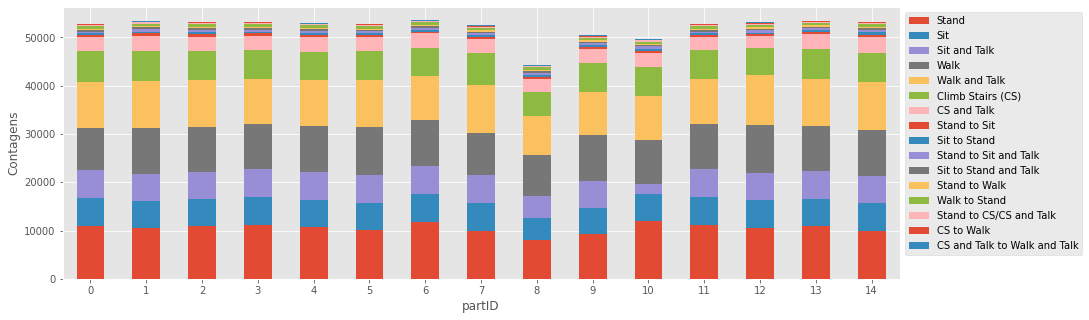

In [ ]:
# PLOT inicial para ver a distribuicao/qualidade dos dados
plt.style.use('ggplot')

ax = pd.pivot_table(data[['partID','label']], index='partID', columns='label',
                          aggfunc=len).plot.bar(stacked=True,figsize=(15,5))

ax.set_ylabel('Contagens');   
ax.legend(act_labels,bbox_to_anchor=(1.0, 1.0)); # legenda do codigo de cores utilizado; legenda fora dos eixos
ax.set_xticklabels(ax.get_xticks(), rotation = 0); # eixo do x sem rotacao
ax.plot()

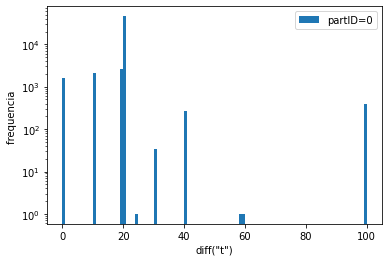

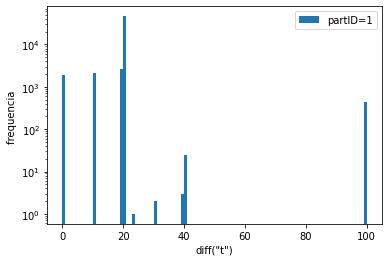

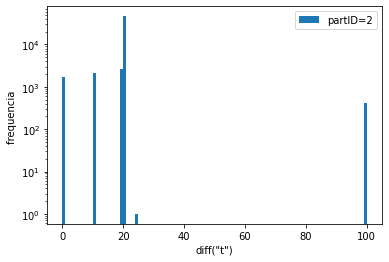

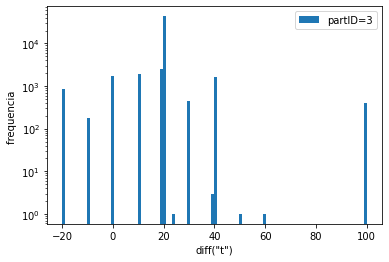

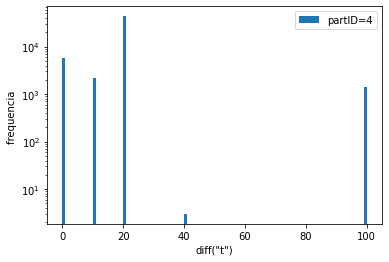

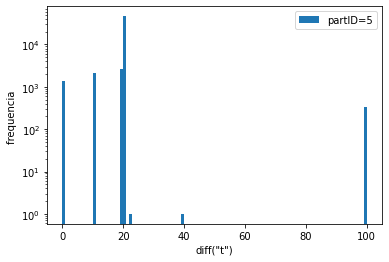

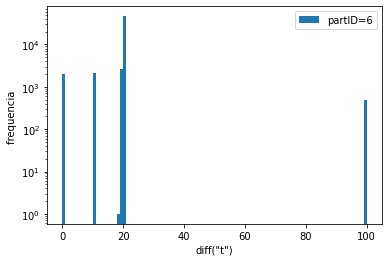

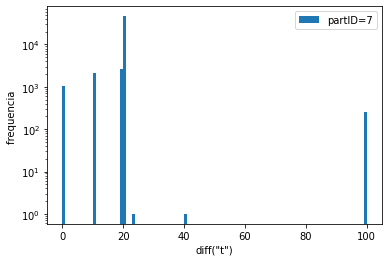

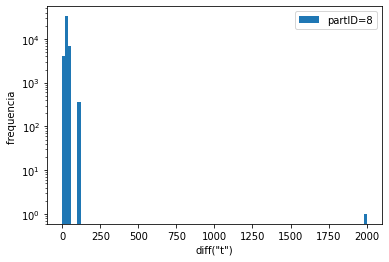

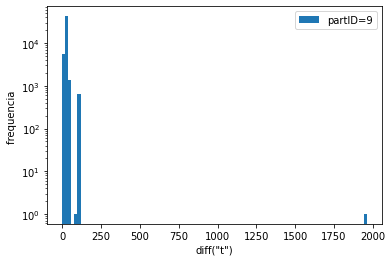

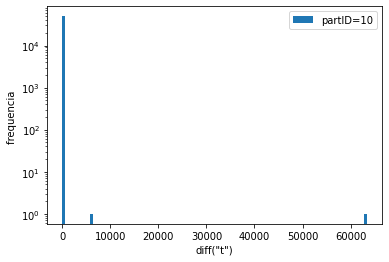

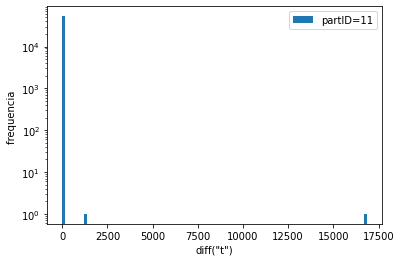

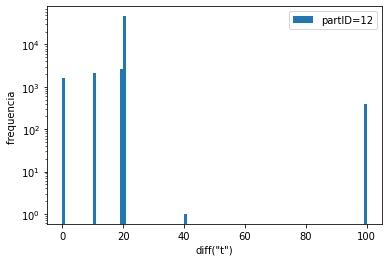

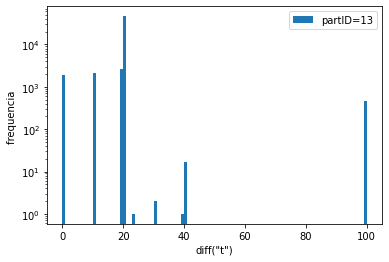

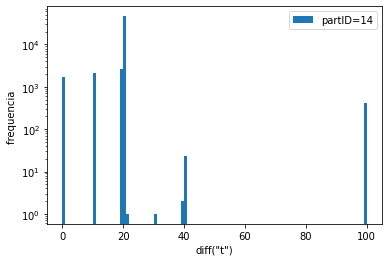

In [ ]:
# PLOT para ver as descontinuidades na coluna do tempo (importante para as janelas)
for name,group in data.groupby('partID'): # qualidade dos dados
  plt.figure()
  plt.hist(group['t'].diff(), bins=100)
  plt.legend(['partID='+str(name)])
  plt.yscale('log')
  plt.ylabel('frequencia ')
  plt.xlabel('diff("t")')

# **Ex. 3.1: módulos aceleração, giroscópio e magnetómetro**

In [ ]:
# calcula o modulo de um vetor com componentes x,y e z
def modulo(x,y,z):
  return np.sqrt(x**2+y**2+z**2)


data['acc_mod']  = modulo(data['accX'] , data['accY'] , data['accZ'])
data['gyro_mod'] = modulo(data['gyroX'], data['gyroY'], data['gyroZ'])
data['mag_mod']  = modulo(data['magX'] , data['magY'] , data['magZ'])


In [ ]:
data

,deviceID,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ,t,label,partID,move,acc_mod,gyro_mod,mag_mod
0,2,3.0317,9.0450,3.1739,0.76247,3.7071,-0.31384,0.57764,0.68849,1.2654,63.629,1,0,Stand,10.053699,3.797690,1.552071
1,2,2.9591,9.0436,3.1400,0.40588,4.6682,-0.10148,0.58385,0.68849,1.2741,83.160,1,0,Stand,10.020108,4.686910,1.561483
2,2,2.9465,9.0545,3.0799,0.24230,5.5225,0.34857,0.56522,0.67857,1.2675,102.690,1,0,Stand,10.007578,5.538792,1.544826
3,2,2.7898,9.0528,3.0726,0.49858,6.3463,0.61127,0.56108,0.65476,1.2610,122.220,1,0,Stand,9.958767,6.395135,1.527626
4,2,2.6924,9.0377,2.9794,0.63197,6.6972,1.00560,0.57764,0.69246,1.2675,141.750,1,0,Stand,9.889685,6.801699,1.555547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53243,2,1.6802,9.5395,2.9636,0.83324,1.9832,0.87140,-0.38716,0.87103,1.3289,1042000.000,1,14,Stand,10.129564,2.320928,1.635409
53244,2,1.7042,9.5639,2.9504,1.03060,1.8002,0.54192,-0.37474,0.86508,1.3399,1042000.000,1,14,Stand,10.152701,2.143953,1.638330
53245,2,1.7283,9.5641,2.9496,1.05330,1.3577,0.89447,-0.35818,0.92857,1.3531,1042000.000,1,14,Stand,10.156730,1.937232,1.679707
53246,2,1.7285,9.5646,2.9737,1.03550,1.4340,0.78856,-0.36232,0.90675,1.3377,1042000.000,1,14,Stand,10.164260,1.936606,1.656174


## **Ex. 3.1: Boxplots**

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

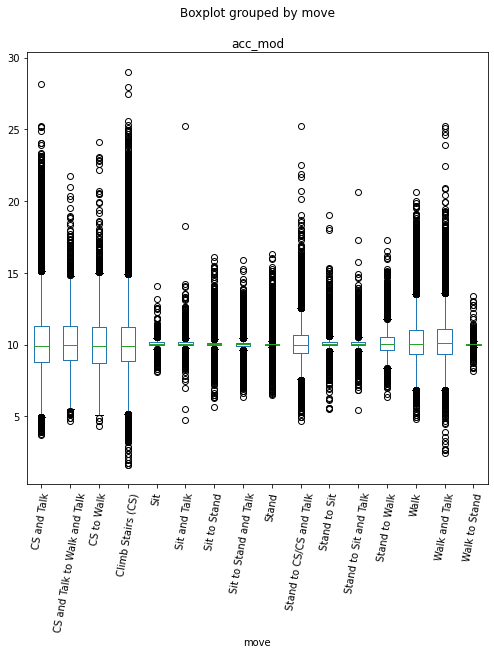

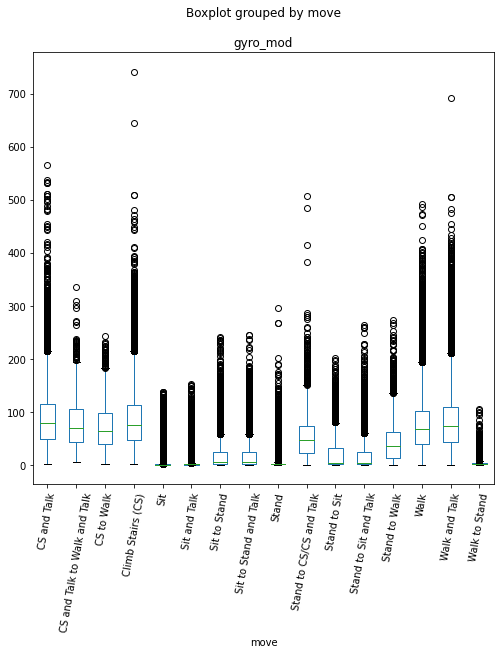

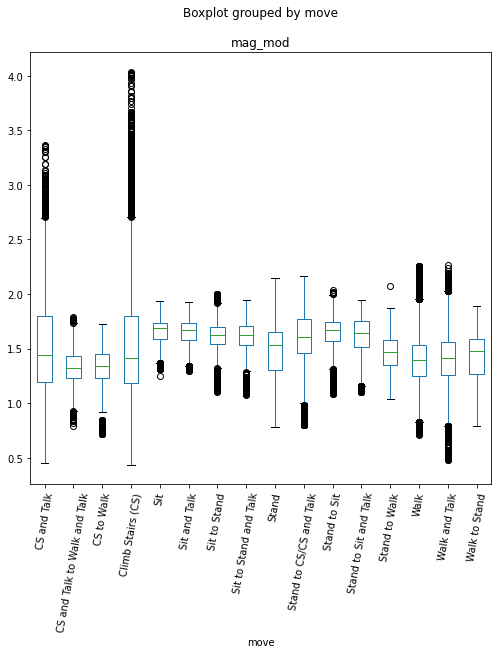

In [ ]:
# Imprime os boxplots com a distribuicao do modulos dos 3 vetores (acc, gyro e mag)
# para cada atividade humana
data.boxplot(column='acc_mod',by='move', figsize=(8,8), grid=False, rot=80)
data.boxplot(column='gyro_mod',by='move', figsize=(8,8), grid=False, rot=80)
data.boxplot(column='mag_mod',by='move', figsize=(8,8), grid=False, rot=80)

# **Ex. 3.2: Densidade de Outliers**

In [ ]:
# devolve o valor do 1º e do 3º quartil
def quartis(data,feature,act_label):
  Q1 = data[feature][data['label']==act_label].quantile(0.25)
  Q3 = data[feature][data['label']==act_label].quantile(0.75)
  return Q1, Q3

# devolve os conjuntos de valores que sao outliers e os que nao o sao
def getOutliers(data,feature, act_label,k=1.5):
  Q1, Q3 = quartis(data,feature, act_label);
  IQ = Q3 - Q1
  ll, ul = [Q1-k*IQ, Q3 + k*IQ]
  
  """ cuidado com a syntax do pandas:
  outliers = data.loc[data['label']==act_label, [feature<ll | feature>ul]] # output e' DataFrame
  outliers = data[feature][data['label']==act_label] # output e' array
  """

  outliers = data.query('label== @act_label & (@ll>{0} or {0}>@ul)'.format(feature))[[feature]]
  non_outliers = data.query('label== @act_label & (@ll<= {0}<= @ul)'.format(feature))[[feature]]
  
  return outliers, non_outliers

# devolve a densidade de outliers
def density_outliers(data,feature,act_label,k=1.5):
  outliers, non_outliers= getOutliers(data,feature,act_label,k)
  
  n0 = outliers.shape[0]/(outliers.shape[0]+ non_outliers.shape[0])*100
  return n0


dfDensOutliers = pd.DataFrame()
for feature in ['acc_mod','gyro_mod','mag_mod']:

  n0=[]
  for act_label in range(1,17):
    n0.append(density_outliers(data, feature, act_label))
  
  dfDensOutliers['densOut ' +feature] = np.array(n0)

# opcionais: apresentar a string com o movimento em vez de so' a dummy variable
# e uma linhha com o sumatorio das densidades de outliers
dfDensOutliers.insert(0,'move',act_labels)
dfDensOutliers.loc['Total']=dfDensOutliers.sum(numeric_only= True)

display(dfDensOutliers)

,move,densOut acc_mod,densOut gyro_mod,densOut mag_mod
0,Stand,4.195538,9.484932,0.000000
1,Sit,0.215558,6.646580,6.672780
2,Sit and Talk,0.513851,9.117459,4.766364
3,Walk,3.530950,1.620764,1.450684
4,Walk and Talk,3.477656,1.428009,1.338803
5,Climb Stairs (CS),5.165680,1.498450,0.390559
6,CS and Talk,4.514626,2.073485,0.221507
7,Stand to Sit,15.444712,7.466947,3.485577
8,Sit to Stand,19.797585,10.777699,7.350852
9,Stand to Sit and Talk,15.324519,10.336538,0.841346


:Concluimos que o sensor de acc é o que tem maior densidade de outliers, relativamente aos outros 2 sensores

# **Ex. 3.3 e 3.4: Z-score**

In [ ]:
# Para evitar que no calculo do Z-score (bloco de codigo seguinte), o pc esteja
# sempre a calcular as medias e os desvios-padrao, criamos esta matriz com precisamente
# os valores das medias e dos desvio padrao.
features=['acc_mod','gyro_mod','mag_mod']
features_means_stds= data.groupby('label', as_index=False)[features].mean()
features_means_stds = features_means_stds.rename(columns={"acc_mod": "mean acc_mod", "gyro_mod": "mean gyro_mod", "mag_mod": "mean mag_mod"}) # o comando da linha anterior da' nomes automaticos as colunas
features_means_stds.insert(1,'move',act_labels)
features_means_stds
features_means_stds[['std '+ x for x in features]] =data.groupby('label', as_index=False)[features].std()[features]
features_means_stds


,label,move,mean acc_mod,mean gyro_mod,mean mag_mod,std acc_mod,std gyro_mod,std mag_mod
0,1,Stand,10.015259,2.804548,1.465578,0.178365,6.929277,0.243099
1,2,Sit,10.067918,0.970612,1.652623,0.124303,4.079555,0.114382
2,3,Sit and Talk,10.062618,1.523562,1.636599,0.149319,4.779960,0.154119
3,4,Walk,10.279495,73.844010,1.381716,1.456592,46.176876,0.217867
4,5,Walk and Talk,10.321383,79.568796,1.393240,1.483780,49.459950,0.234918
5,6,Climb Stairs (CS),10.280865,83.995705,1.493448,2.335049,49.370427,0.361287
6,7,CS and Talk,10.302225,87.000447,1.496533,2.359249,51.242655,0.353352
7,8,Stand to Sit,10.065107,21.654415,1.638102,0.617361,31.785909,0.154081
8,9,Sit to Stand,10.041196,20.084009,1.600434,0.644955,31.795825,0.156915
9,10,Stand to Sit and Talk,10.061016,18.853339,1.626814,0.557977,30.968999,0.162045


In [ ]:
# estou a calcular as medias e o std em separado para cada atividade
def compute_zscore(data,feature):
  # esta' escrito de uma forma mais compacta por uma razao de desempenho
  # mas e' equivalente ao seguinte:
  #df= pd.DataFrame()
  #means = [features_means_stds["mean " + feature][i] for i in data["label"]-1]
  #stds  = [features_means_stds["std " + feature][i] for i in data["label"]-1]
  #df['zscore'] = (data[feature] - means ) / stds
  # return df
  df = data.groupby('label', as_index=False)[feature].transform(lambda x: (x - x.mean()) / x.std())
  df = df.rename(columns={feature: "zscore"})
  return df


def zscore_outliers(data,feature,k):
  outliers = data.query('{0}< -@k or {0}> @k'.format(feature))# generalizar o nome da feature
  non_outliers = data.query('-@k<= {0}<= @k'.format(feature))# generalizar o nome da feature
  return outliers, non_outliers

def plot_zscore_2colors(data,feature,k):
  zfeature= "zScore"+feature.split('_')[0].capitalize() # um pequeno workaroud
  #porque a feature que queremos no zscore_outliers tem um nome ligeiramente diferente da que queremos nos plots
  outliers, non_outliers = zscore_outliers(data,zfeature,k)

  ax= outliers.plot(kind='scatter', x='label', y=feature, c='r', ax=plt.gca()) # ax=plt.gca() para fazer o plot no subplot selecionado  
  non_outliers.plot(kind='scatter', x='label', y=feature, c='b', ax=ax) # ax=ax e' o equivalente ao "hold on"
  ax.set_title('Z-Score K='+str(k))


## calcula o z-score
data['zScoreAcc'] = compute_zscore(data,"acc_mod")
data['zScoreGyro'] = compute_zscore(data,"gyro_mod")
data['zScoreMag'] = compute_zscore(data,"mag_mod")


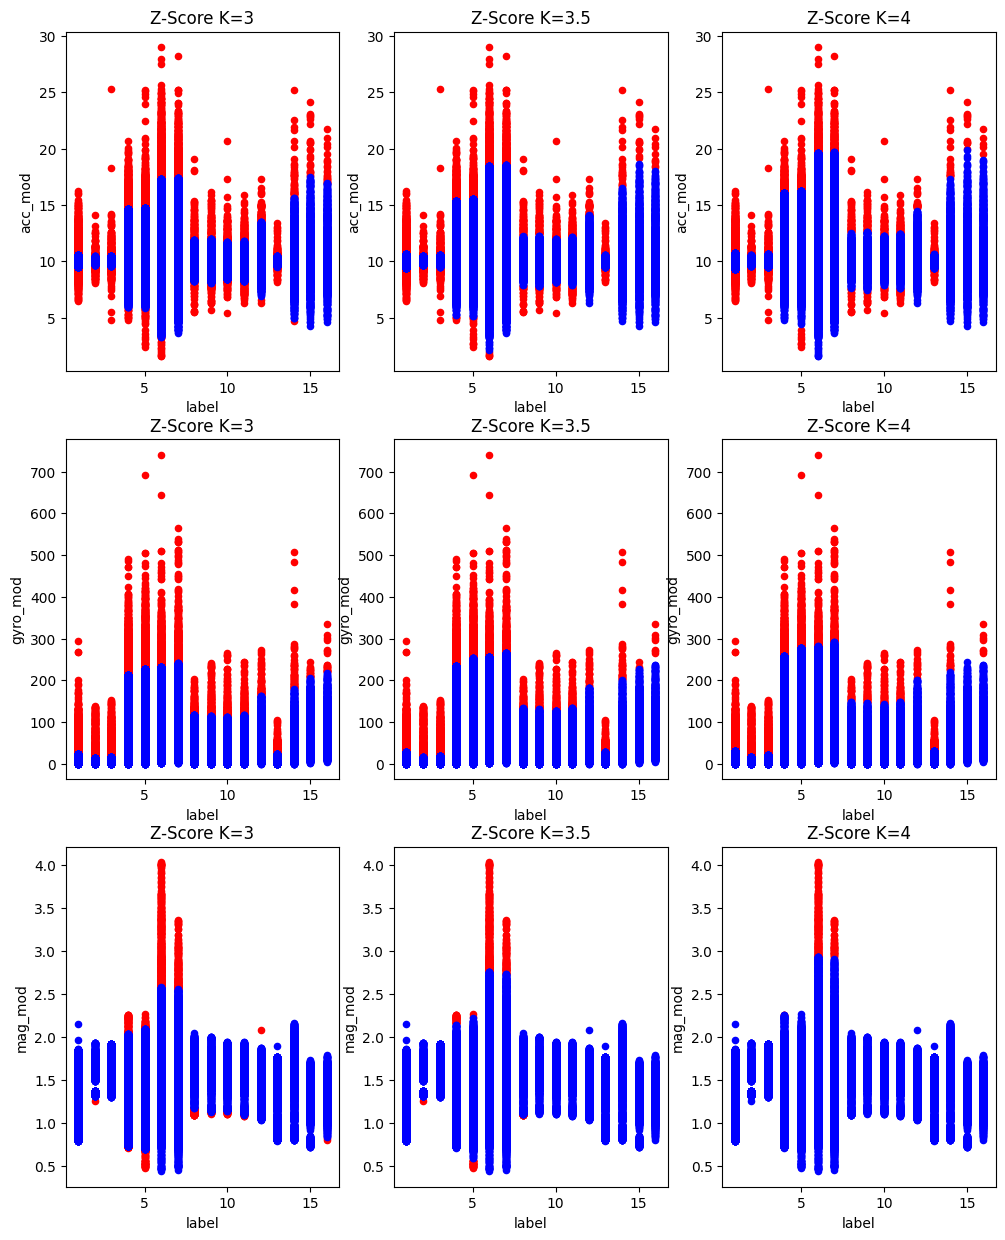

In [ ]:
## faz os graficos do z-score numa janela 3x3
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(12,15))
i=0
for k in [3, 3.5,4]:
  plt.sca(axes[0,i])
  plot_zscore_2colors(data,"acc_mod",k)
  plt.sca(axes[1,i])
  plot_zscore_2colors(data,"gyro_mod",k)
  plt.sca(axes[2,i])
  plot_zscore_2colors(data,"mag_mod",k)
  i+=1

0     [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
1     [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
2     [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
3     [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
4     [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
5     [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
6     [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
7     [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
8     [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
9     [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
10    [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
11    [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
12    [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
13    [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
14    [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
15    [[AxesSubplot(0.125,0.11;0.215278x0.77), AxesS...
dtype: object

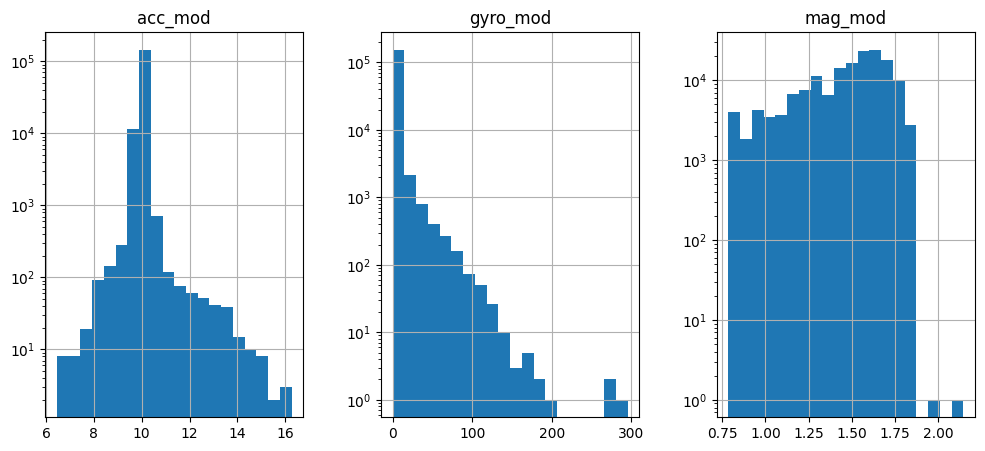

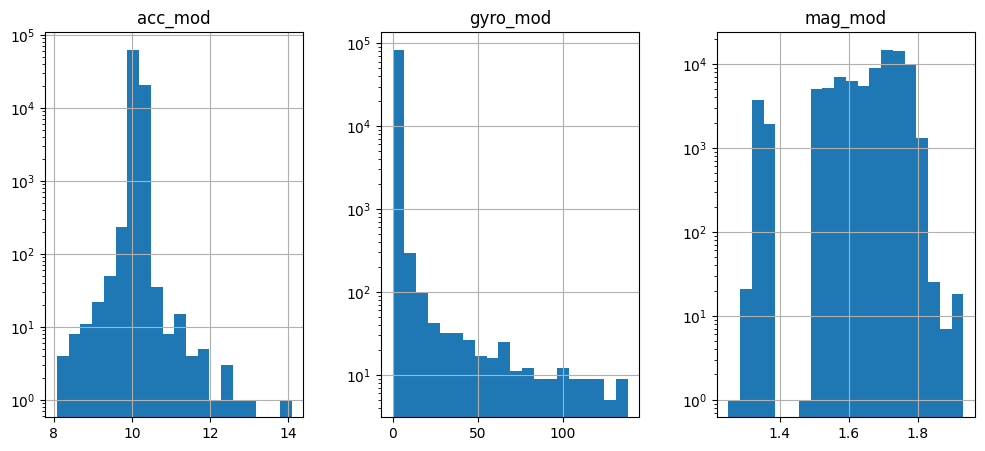

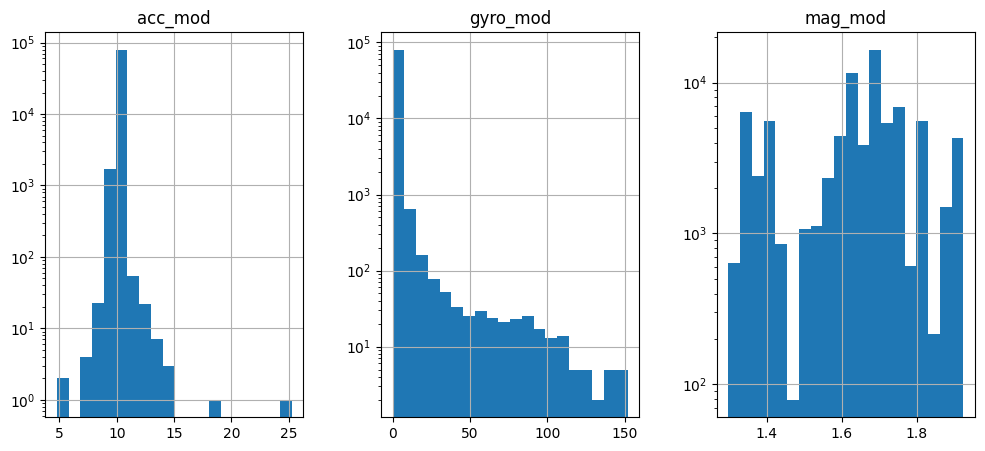

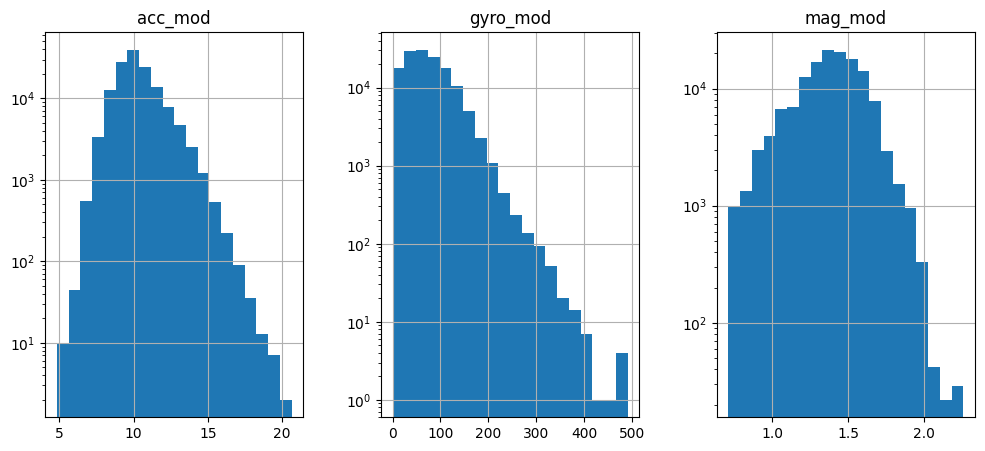

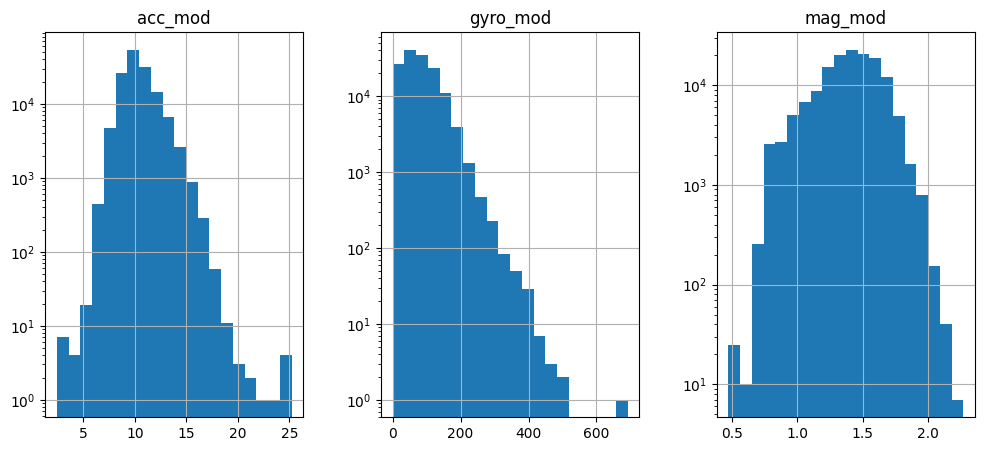

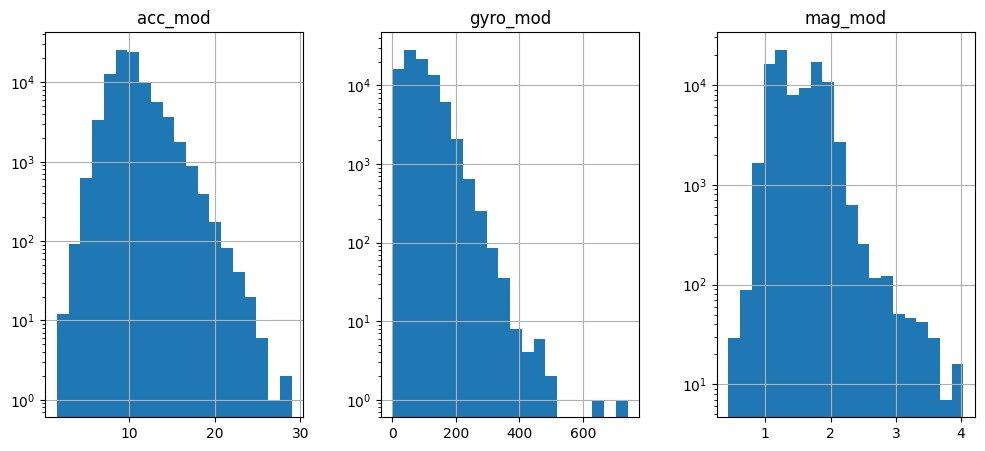

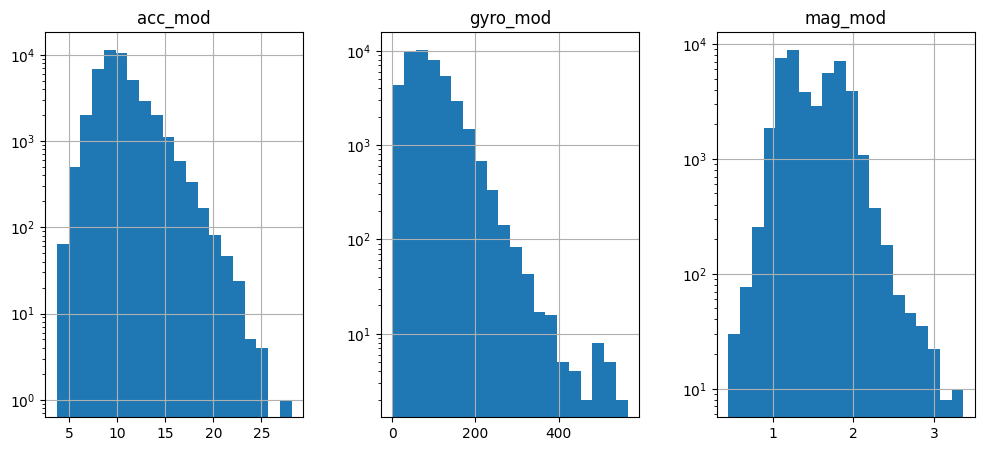

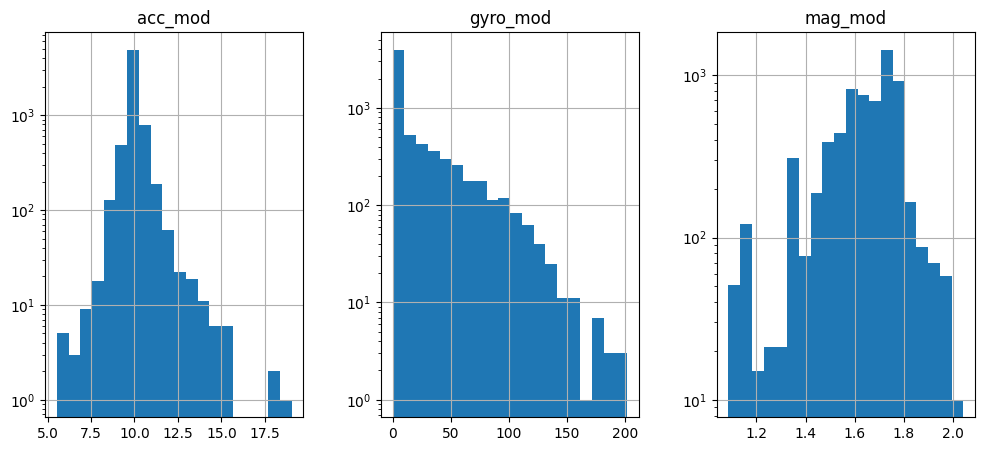

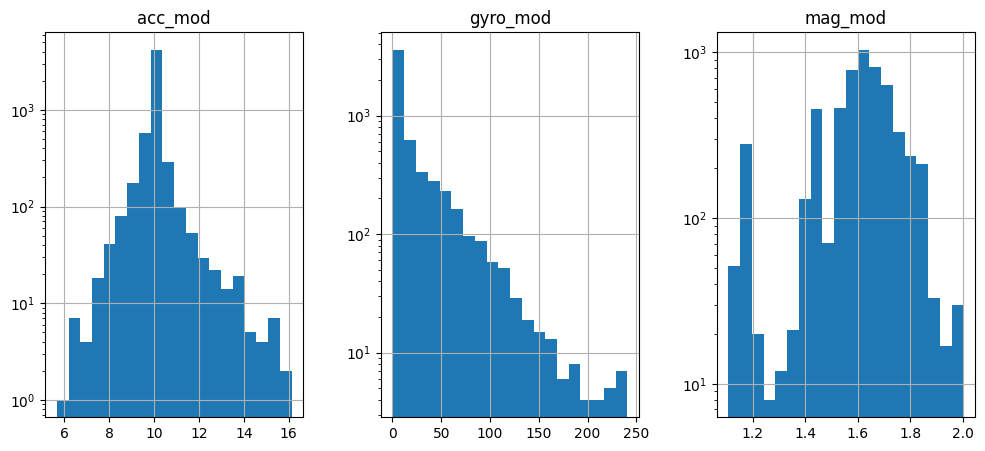

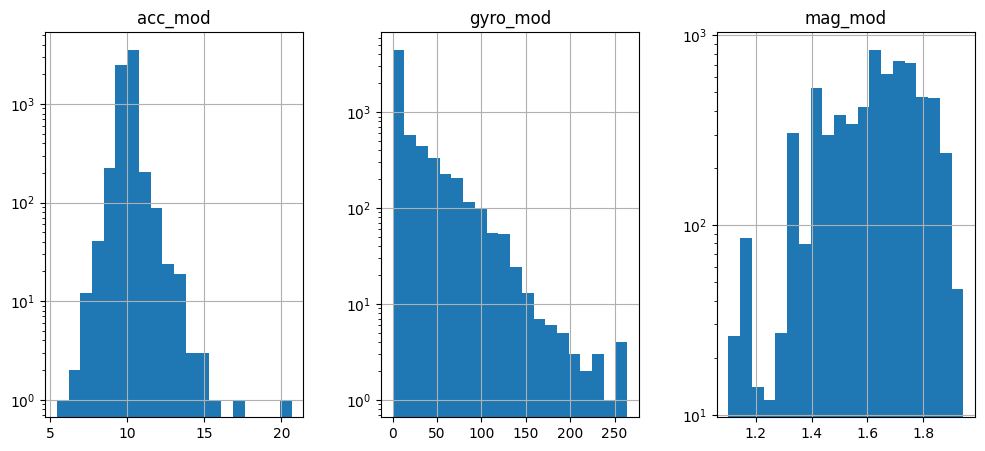

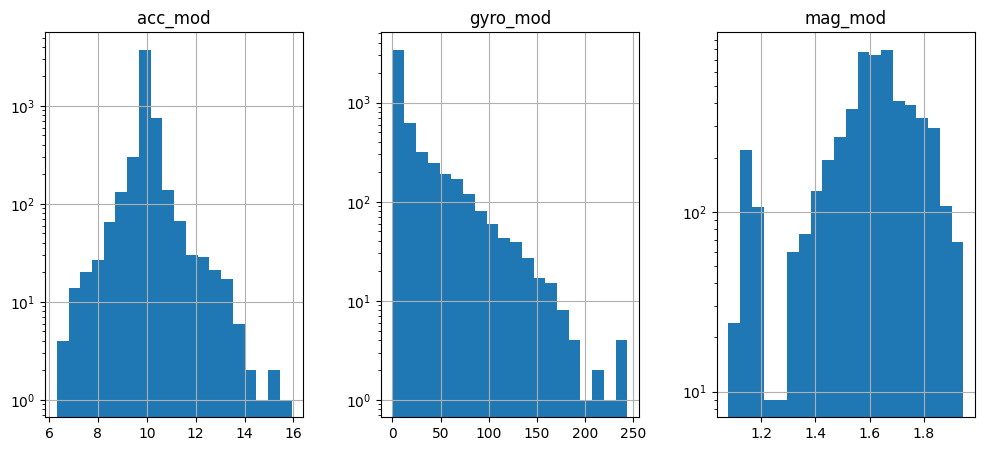

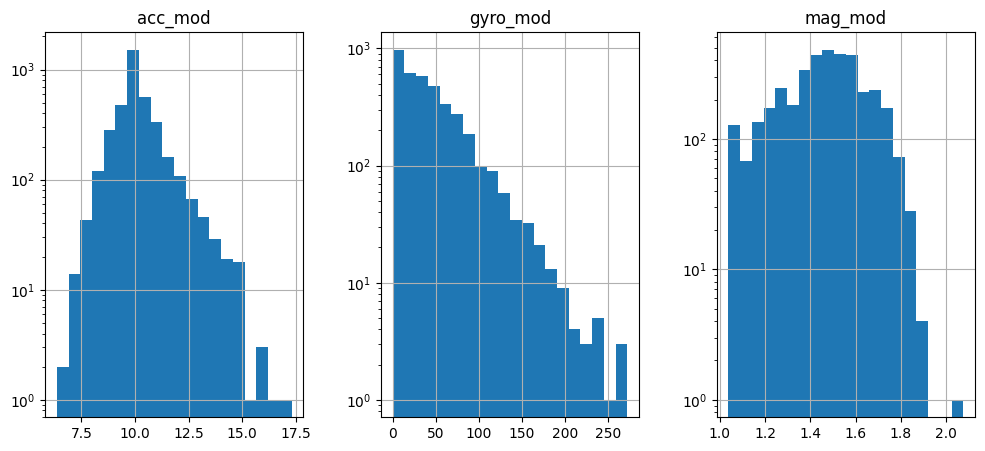

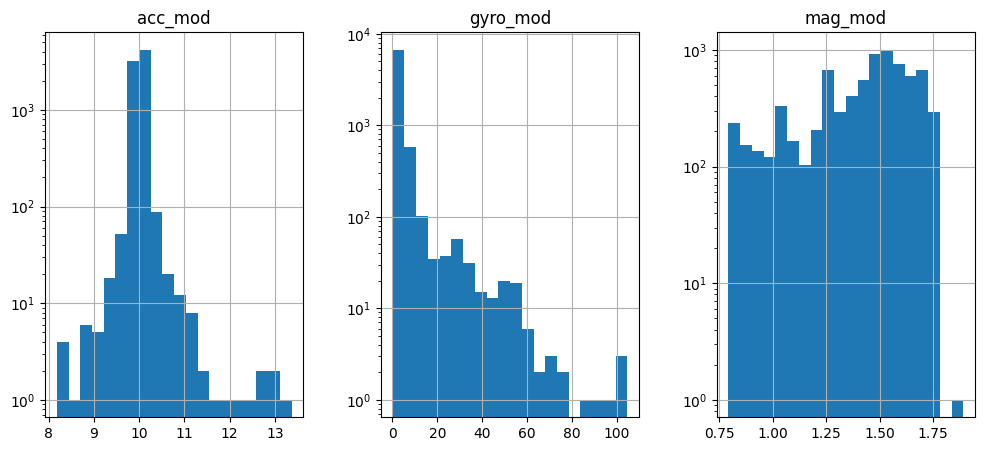

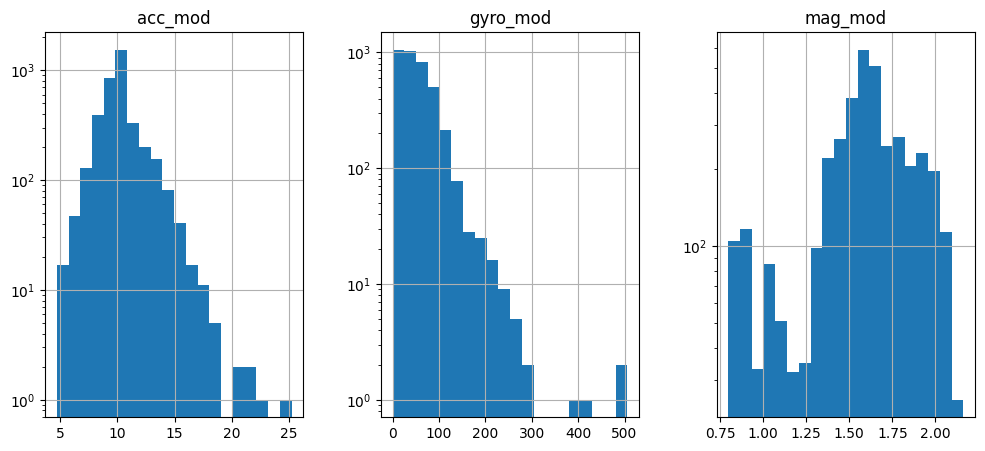

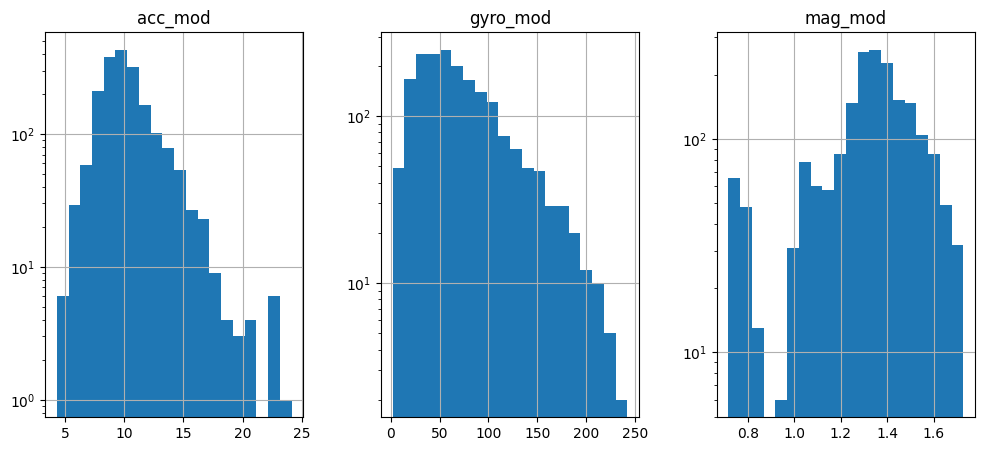

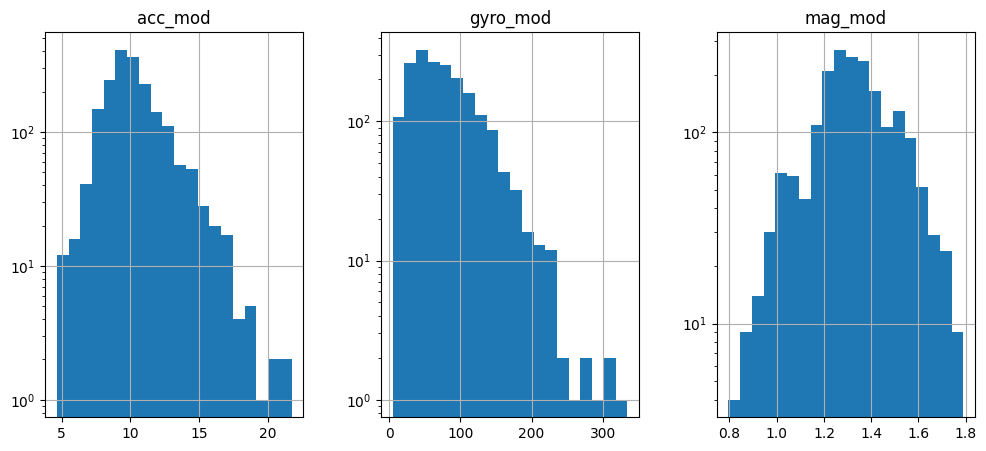

In [ ]:
data.groupby('label',as_index=False).hist(column=['acc_mod','gyro_mod','mag_mod'],layout=(1,3),bins=20,log= True, figsize=(12,5)) # estava a ver que
#distribucoes do acc_mod de cada atividade segue, porque estou a achar estranho
#que no grafico do zscore (bloco de codigo de cima), para algumas atividades (por exemplo, 16)
#praticamente so' existem outliers (pontos vermelhos) de um lado


# **Ex. 3.5: Comparar resultados**
Compare e discuta os resultados obtidos em 3.1 e 3.4.

---

Valores padrão para considerarmos outliers:
- Z-score: Z>3
- IQR: IQR=1.5

---

- Para k maiores, o numero de outiers diminui (o faz sentido tendo em conta a operação realizada).
- Pelo boxplot identificamos sempre outliers dos 2 lados do intervalo de valores enquanto que com o Z-score nem sempre. A razão está nas ditribuições (ver resultados do bloco de código anterior)


In [ ]:
#Obter o numero de outliers para comparar quantitativamente
_, outliers = zscore_outliers(data,'zScoreAcc',3)
# 
display(pd.pivot_table(outliers[['partID','label']], index='partID', columns='label',
                          aggfunc=len))
# TOTAL de outliers por participante
display(pd.pivot_table(outliers[['partID','label']], index='partID', columns='label',
                          aggfunc=len).sum())

label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
partID,,,,,,,,,,,,,,,,
0,10857,5755,5755,8687,9463,6512,2814,380,375,375,378,249,508,252,127,127
1,10498,5626,5622,9456,9719,6221,3062,502,378,506,381,253,508,254,125,127
2,10863,5623,5631,9346,9730,6017,2945,504,384,511,379,254,508,247,127,127
3,10959,5738,5755,9090,9095,5658,2842,500,368,376,364,248,508,245,119,118
4,10755,5604,5733,9460,9231,5737,2967,503,367,375,363,250,508,252,127,127
5,10109,5630,5704,9817,9826,5815,2906,382,377,504,256,254,508,242,125,125
6,11770,5756,5748,9596,9171,5759,2936,384,384,377,382,254,447,254,126,124
7,9706,5760,5760,8594,9778,6619,2918,351,377,354,352,250,508,242,127,126
8,8044,4480,4607,8408,8119,4983,2554,374,378,508,364,242,508,254,126,125


label
1     156554
2      83769
3      80857
4     138437
5     140844
6      88196
7      43196
8       6534
9       5489
10      6508
11      5215
12      3740
13      7526
14      3760
15      1881
16      1881
dtype: int64

In [ ]:
# Fiz isto para termos numeros para compararmos quantitativamente o que e' pedido
# Podemos comparar as fracoes porque estao normalizadas ao mesmo

# Faz sentido o Z-score dar menos outliers pelo seguinte:
# - estamos a usar k=3 -> se os dados seguirem uma distribuicao normal
#    entao apenas 5% sao considerados outliers
# - como na verdade algumas distribuicoes nao sao normais, e sao assimetricas
#    nessas o z-score ainda identica menos outliers
# - nas distruibuicoes assimetricas, podem nao haver outliers num dos dados
#    (vimos isso nos plots!) enquanto que com o IQR havera' sempre outliers
#    dos dois lados do espetro

dfOutliers = pd.DataFrame()
for feature in ['acc_mod','gyro_mod','mag_mod']:

  n0=[]
  for label in range(1,17):
    subset = data[data['label']==label][[feature,'label']].copy()
    subset['zScore'] = compute_zscore(subset,feature)
    subset['isOutlier'] = abs(subset['zScore'])>3;
    densityOutliers = len(subset[subset['isOutlier']==True])/len(subset)*100
    n0.append(densityOutliers)
  dfOutliers['densOut ' +feature] = np.array(n0)


dfOutliers.insert(0,'move',act_labels)
dfOutliers.loc['Total']=dfOutliers.sum(numeric_only= True)

display(dfOutliers)

,move,densOut acc_mod,densOut gyro_mod,densOut mag_mod
0,Stand,0.841135,1.487187,0.000000
1,Sit,0.236995,0.466845,0.001191
2,Sit and Talk,0.363515,0.638308,0.000000
3,Walk,1.069790,0.910429,0.082896
4,Walk and Talk,1.069075,0.867482,0.064622
5,Climb Stairs (CS),1.301492,0.906456,0.493515
6,CS and Talk,1.358727,1.096116,0.365372
7,Stand to Sit,1.832933,1.832933,2.524038
8,Sit to Stand,2.539062,2.183949,0.177557
9,Stand to Sit and Talk,2.223558,2.118389,0.375601


# **Ex. 3.6 k-means**

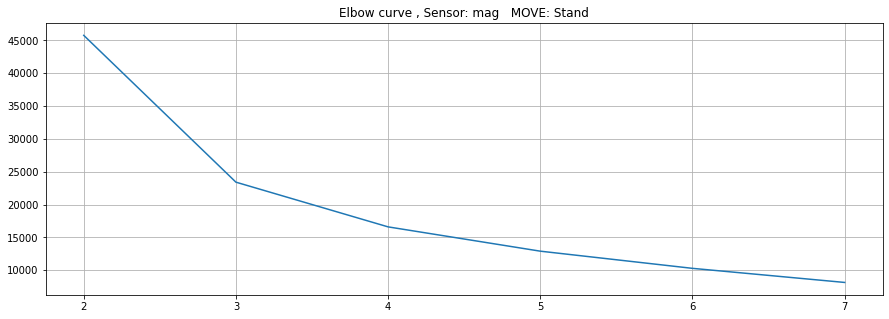

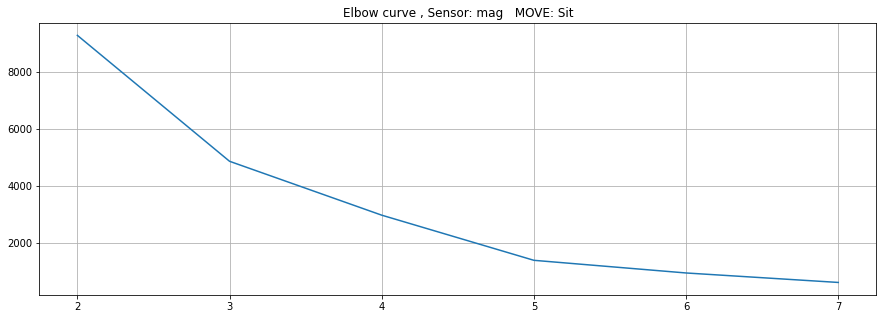

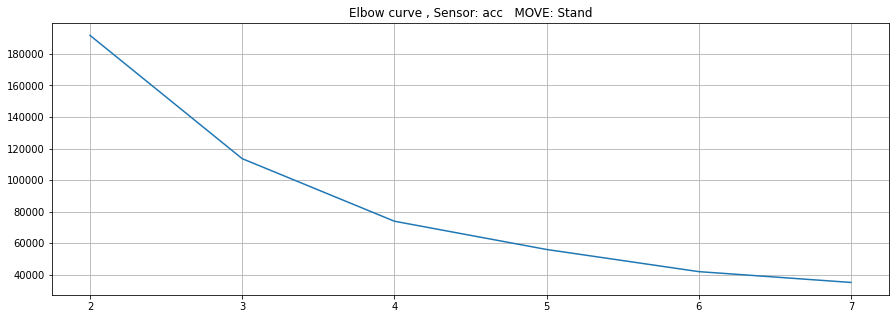

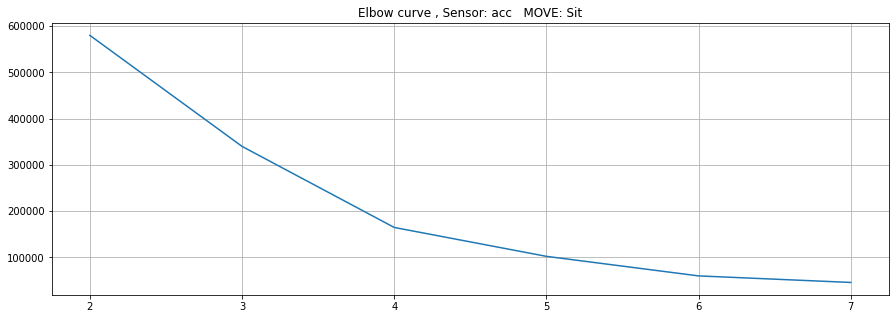

In [ ]:
def calculate_distance(data, centers):
  distance = np.zeros((len(data),len(centers)))
  for i, center in enumerate(np.array(centers)):
      diff = np.array(data)-center
      distance[:,i] = np.linalg.norm(diff,axis=1)
  return distance

def assign_center(data, centers):
  distance = calculate_distance(data, centers)
  labels = np.argmin(distance, axis = 1)
  min_distance = np.amin(distance, axis=1)
  loss = min_distance.sum()
  return labels, loss

def calculate_center(data, labels):
  temp = data.copy()
  temp['labels'] = labels
  centers = temp.groupby('labels').agg('mean')
  return centers

def k_means(data, K, max_interations):
  ### Initializing centers
  centers = data.sample(K,replace=False)
  loss_prev = -1    
  iteration = 0
  loss = 0
  labels =0
  while iteration < max_interations:
    ###assign data to its nearest center
    labels, loss = assign_center(data, centers)
    
    ###calculate new centers
    centers = calculate_center(data, labels)
    
    ###condition of convergence
    if loss == loss_prev:
        break
        
    loss_prev = loss
    iteration+=1    
  
  return labels, centers, loss

def make_frame_new(sensor, move):
  dataFrame_to_plot = pd.DataFrame()
  dataFrame_to_plot = data[data["move"] == move][[sensor + "X", sensor + "Y", sensor + "Z"]]

  return dataFrame_to_plot



def elbow(sensor,move, k_max):

  dataFrame_to_plot = make_frame_new(sensor,move)
  silhouette_avg = []

  distorsions = []
  for k in range(2, k_max):
      kmeans = KMeans(n_clusters=k)
      kmeans.fit(dataFrame_to_plot)
      distorsions.append(kmeans.inertia_)

  fig = plt.figure(figsize=(15, 5))
  plt.plot(range(2, k_max), distorsions)
  plt.grid(True)
  plt.title('Elbow curve , Sensor: '+sensor + "   MOVE: "+ move)
  plt.show()


elbow('mag',"Stand",8)
elbow('mag',"Sit",8)

elbow('acc',"Stand",8)
elbow('acc',"Sit",8)



In order to find the optimal number of clsuters in k means, we used the sillouete score, which  measures how similar observation is to the assigned cluster and how dissimilar to the observation of nearby cluster.

silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.

 - 1: Means clusters are well apart from each other and clearly distinguished.

 - 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.

 - -1: Means clusters are assigned in the wrong way.

 https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c

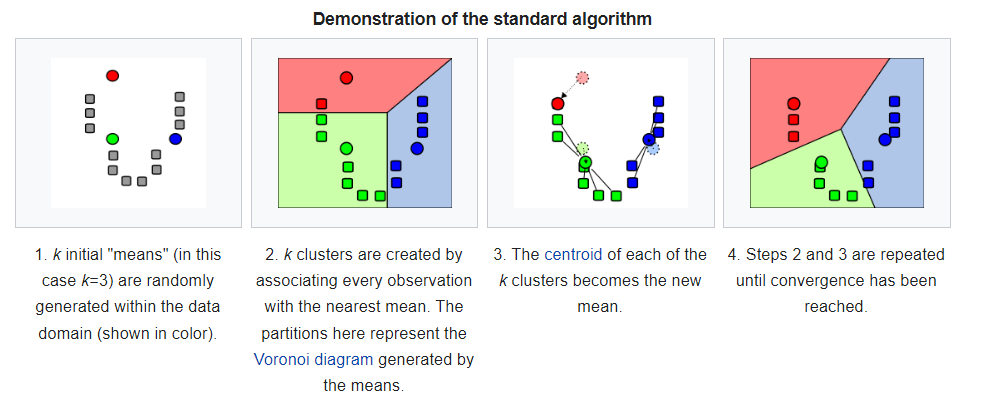

## K-means com identificacao de outliers

Doing kmeans with k = 2 ...
Doing kmeans with k = 4 ...
Doing kmeans with k = 6 ...
Doing kmeans with k = 8 ...
Doing kmeans with k = 10 ...
Doing kmeans with k = 12 ...
Doing kmeans with k = 14 ...
Doing kmeans with k = 16 ...
Doing kmeans with k = 18 ...
Doing kmeans with k = 20 ...
Doing kmeans with k = 22 ...
Doing kmeans with k = 24 ...
Doing kmeans with k = 26 ...
Doing kmeans with k = 28 ...


Text(0.5, 1.0, 'Distortion, acc')

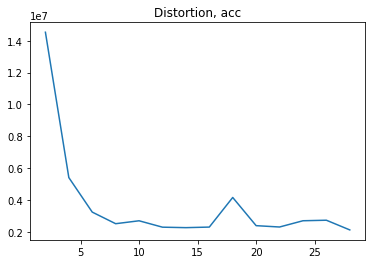

In [ ]:
np.random.seed(seed=21)
MAX_ITERATIONS = 20

# Function: Get Random Centroids
def getRandomCentroids(dataSet,k):
    nRows = dataSet.shape[0];
    randomIdx = np.random.choice(nRows, k, replace= False)
    return dataSet.iloc[randomIdx] 

def keepIterating(oldCentroids, centroids, iterations):
    # Devolve True se devemos de continuar a iterar.
    # Devolve False se o resultado ja' convergiu ou se ja' iteramos o numero
    # maximo de vezes
    return not (iterations==MAX_ITERATIONS or oldCentroids.equals(centroids))

def calculateDistances(data,centroids):
    # Calcula a distancia de cada ponto a cada centroid em centroids
    distances = pd.DataFrame()
    for i in range(len(centroids)):
        distances['dist2cluster'+str(i)]=np.sqrt(np.square(data-centroids.iloc[i]).sum(axis=1))
    
    return distances


def getLabels(distances, centroids):
    # Ve para cada ponto qual o cluster mais perto. Atribuimos este ponto a esse cluster.
    #idxmin(axis=1) devolve o nome da coluna com menor valor
    #replace: para que o resultado final seja apenas o numero do cluster e nao o nome completo da coluna (e.g. cluster2 -> 2)
    nearestCluster = distances.idxmin(axis=1).str.replace("dist2cluster","").astype(int)
    return nearestCluster

def getCentroids(dataSet):
    # Calcula os centroides. Os centroides sao o valor médio de todos os
    # pontos que pertencem a um cluster
    return dataSet.groupby('cluster',as_index=False).mean().drop(columns=['cluster'])

def getOutliers(dataSet,distances,k=3):
    #https://medium.datadriveninvestor.com/outlier-detection-with-k-means-clustering-in-python-ee3ac1826fb0
    #A maneira de "definir" os outliers e' atraves de um threshold do
    # quao longe os pontos estao do centro do cluster
    METHOD = 2;
    if METHOD==1:
      distances_ = (distances-distances.mean()) /distances.std()
      outliers = distances_[ abs(distances_.min(axis=1)) > k ]
      return dataSet.iloc[outliers.index]
    else:
      clustersSizes = pd.DataFrame(dataSet.groupby(['cluster']).size() / len(dataSet), columns=['density'])
      clustersSizes['isOutliers'] = clustersSizes < 0.05
      return clustersSizes

def calculateDistortion(distances):
    # Calcula a distorcao do algoritmo. A distorcao e' a soma dos quadrados da
    # distancia de cada ponto ao centroide do cluster a que pertence.
    return np.sum(distances.min(axis=1)**2)

# assim as varias funcoes ficam muito mais simples se passarmos logo uma variavel com as
# 3 colunas desejadas (X,Y,Z) do que se passarmos a dataframe toda
def kmeans(dataSet,k,k_zscore=3):
	
    # Inicializar k centroides aleatorios
    centroids = getRandomCentroids(dataSet,k)
    
    # Inicializar variaveis de controlo
    iterations = 0
    oldCentroids = pd.DataFrame(index=range(k),columns=centroids.columns)
    
    # Iteracoes do k-means
    while keepIterating(oldCentroids, centroids, iterations):
        # Guardar os centroides para mais tarde(proxima iteracao) comparar
        oldCentroids = centroids
        iterations += 1
        
        # Determinar o cluster a que pertencem os pontos baseados na distancia
        distances = calculateDistances(dataSet,centroids)
        labels = getLabels(distances, centroids)
        dataSet['cluster']=labels
        # Recalcucar (atualizar) os centroides. Calcular a distorcao.
        centroids = getCentroids(dataSet)
        distortion = calculateDistortion(distances)
        
    outliers = getOutliers(dataSet,distances,k_zscore)
    return labels, centroids, outliers, distortion

    
### FIM DAS FUNCOES 

### SO' PRECISAMOS DE ESCOLHER O SENSOR, E O RANGE PARA O K
sensor='mag'
range_k= range(2,30,2)


dataSet = data[[sensor+'X',sensor+'Y',sensor+'Z']].copy()
labels_results = {k:[] for k in range_k}
centroids_results = {k:[] for k in range_k}
outliers_results = {k:[] for k in range_k}
distortion_results = {k:[] for k in range_k}

for idx, k in enumerate(range_k):
    print('Doing kmeans with k =',k,'...')
    labels, centroids, outliers, distortion = kmeans(dataSet,k)
    labels_results[k]=labels; centroids_results[k]=centroids;
    outliers_results[k]=outliers; distortion_results[k]=distortion
# DEMOROU (no loop todo): 4 min 52 s; 5 min 00 s; 5 min 00 s

# plot da curva
plt.plot(range_k, list(distortion_results.values()) )
plt.title('Distortion, ' +sensor)

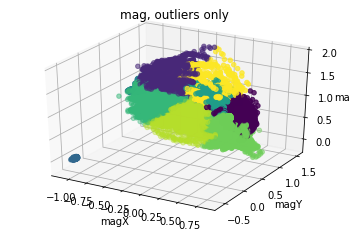

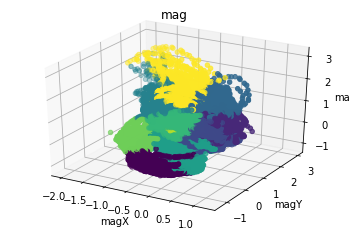

In [ ]:
## PLOT dos outliers pelo METHOD==1 (distancia maxima ao centro do cluster)
PLOT_ONLY_OUTLIERS = True; k=12; # a variavel sensor esta' no bloco de codigo anterior

if PLOT_ONLY_OUTLIERS:
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(outliers_results[k][sensor+'X'], outliers_results[k][sensor+'Y'], outliers_results[k][sensor+'Z'], c=outliers_results[k]['cluster'])
  plt.title(sensor+', outliers only');
  plt.xlabel(sensor+'X');plt.ylabel(sensor+'Y');ax.set_zlabel(sensor+'Z');
#else:
  # atencao 'a interpretacao: os eixos podem estar diferentes do PLOT_ONLY_OUTLIERS
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(dataSet[sensor+'X'], dataSet[sensor+'Y'], dataSet[sensor+'Z'], c=dataSet['cluster'])
  plt.title(sensor);
  plt.xlabel(sensor+'X');plt.ylabel(sensor+'Y');ax.set_zlabel(sensor+'Z');


cluster
2     41633
6     44805
12    39316
20    40626
23    53219
Name: magY, dtype: int64
label
1     73870
2      4593
3      3557
4     42606
5     43714
6     26464
7     11237
8       869
9      2387
10      653
11     2721
12     1208
13     3051
14     1329
15      633
16      707
Name: accX, dtype: int64


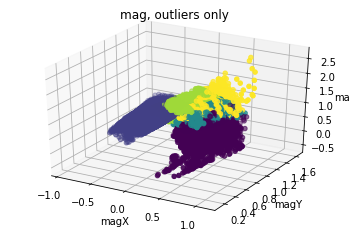

In [ ]:
#### PLOT dos outliers pelo METHOD==2 (densidade de pontos do cluster)
# Grafico
oultiersClusters = outliers_results[k].index[outliers_results[k]['isOutliers'] == False].tolist()
outliersPoints = dataSet[dataSet['cluster'].isin(oultiersClusters)]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(outliersPoints[sensor+'X'], outliersPoints[sensor+'Y'], outliersPoints[sensor+'Z'], c=outliersPoints['cluster'])
plt.title(sensor+', outliers only');
plt.xlabel(sensor+'X');plt.ylabel(sensor+'Y');ax.set_zlabel(sensor+'Z');


# Saber o numero do cluster e quantos pontos ele tem
print(outliersPoints.groupby('cluster').count().iloc[:,1])
# Saber os outliers por label (tipo de movimento) -> para podermos comparar com o z-score
print(data.iloc[outliersPoints.index].groupby('label').count().iloc[:,1])
# NOTA: naturamelmente a soma dos dois prints() anteriores da' o mesmo valor


In [ ]:
"""
dataFrame_to_plot = make_frame_new('acc','Sit')

range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg = []

for num_clusters in range_n_clusters:

  # initialise kmeans
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(dataFrame_to_plot)
  cluster_labels = kmeans.labels_

  # silhouette score
  print(f'Cluster: {num_clusters} ; Silhouette Score: {silhouette_score(dataFrame_to_plot, cluster_labels)}')
  silhouette_avg.append(silhouette_score(dataFrame_to_plot, cluster_labels))



plt.plot(range_n_clusters,silhouette_avg)
plt.show()

K_best = range_n_clusters(np.argmax(silhouette_avg))

print("Melhor valor de Cluster: {K_best}")

"""        



def silhouette_routine(dataFrame_to_plot,range_cluster, to_plot = True):

  range_n_clusters = np.arange(2,range_cluster)
  silhouette_avg = []

  for num_clusters in range_n_clusters:

    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(dataFrame_to_plot)
    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette=silhouette_score(dataFrame_to_plot, cluster_labels)
    print(f'Cluster: {num_clusters} ; Silhouette Score: {silhouette}')
    silhouette_avg.append(silhouette)


  K_best = range_n_clusters(np.argmax(np.array(silhouette_avg)))
  print("Melhor valor de Cluster: {K_best}")


  if to_plot:
    plt.plot(range_n_clusters,silhouette_avg)
    plt.show()



  return K_best

dataFrame_to_plot = data[data["move"] == "Stand"][["accX", "accY","accZ"]]


silhouette_routine(dataFrame_to_plot,5)

Cluster: 2 ; Silhouette Score: 0.9310233170820128
Cluster: 3 ; Silhouette Score: 0.42868988101776023


KeyboardInterrupt: ignored

In [ ]:
def kmeans_w_best_k(silhouette_routine(dataFrame_to_plot,range_cluster):
  best_k = silhouette_routine(dataFrame_to_plot, range_cluster , True)




In [ ]:
def plot_k_means(sensor,move, clusters):   #input mag, acc, gyro
  
  dataFrame_to_plot = make_frame_new(sensor, move)

  labels, centers, loss = k_means(dataFrame_to_plot, clusters, 30)

  new_data = dataFrame_to_plot.copy()
  new_data['labels'] = labels
  R = np.array(new_data)
  
  fig = plt.figure()
  ax = Axes3D(fig)
  ax.scatter(R[:, 0], R[:, 1], R[:, 2],c = R[:,3])
  plt.title("Kmeans "+sensor + "() move :"+ move)
  ax.set_xlabel(sensor+"X"); ax.set_ylabel(sensor+"Y"); ax.set_zlabel(sensor+"Z")
  plt.show()

plot_k_means("acc","Sit",3)
plot_k_means("gyro","Sit",3)
plot_k_means("mag","Sit",3)

## **Ex. 3.7.1 DBScan (extra)**

In [ ]:
# como o codigo demora um pouco temos a flag to_plot=False para suprimir os plots
# quando nao precisamos
def dbscan_plot(data, eps, min_samples, sensor, activity_indice, to_plot=False):
  data_to_clusterise = data[data["label"] == activity_indice][[sensor + "X", sensor + "Y", sensor + "Z"]]
  data_to_clusterise["clusters"] = dbscan(data_to_clusterise, eps=eps, min_samples=min_samples)[1]
  
  if to_plot:
      fig = plt.figure(figsize=(8, 6)).gca(projection='3d')
      plt.title(activities_labels[activity_indice] + " / " + sensor)
      fig.scatter(data_to_clusterise[sensor+"X"], data_to_clusterise[sensor+"Y"], data_to_clusterise[sensor+"Z"], c=data_to_clusterise["clusters"])
      fig.set_xlabel(sensor+"X")
      fig.set_ylabel(sensor+"Y")
      fig.set_zlabel(sensor+"Z")
      plt.show()

In [ ]:
upper_limits_n_clusters = 5
eps = 0.5
min_samples = 1
to_plot = True
max_act_to_plot = 3
contador = 0

# descomentar para correr para varios; comentar para correr mais depressa
#for i in range(activities_labels):
#for j in ['ACC',"GYRO", "MAG"]:
dbscan_plot(data, eps, min_samples, "acc", 2)


"""

for act in activities:
    dbscan_plot(data, eps, min_samples, "ACC", act, to_plot)
    dbscan_plot(data, eps, min_samples, "GYRO", act, to_plot)
    dbscan_plot(data, eps, min_samples, "MAG", act, to_plot)
    if contador == max_act_to_plot - 1:
        to_plot = False
    contador += 1 
"""

## Comentario - DBSCAN

O DBSCAN é um dos métodos de clustering mais usados ​​porque os clusters encontrados pelo DBSCAN podem ter qualquer formato, o que pode lidar com alguns casos especiais que outros métodos não podem

De um modo geral, o DBSCAN é um melhor algoritmo de clustering que o K-Means, não é necessario definir um valor de k  a priori de clusters e suporta formas irregulares de clusters (O DBSCAN não requer nenhuma forma dos clusters, mas rastreia as regiões de alta densidade).



# Referência
[1] https://towardsdatascience.com/understanding-dbscan-and-implementation-with-python-5de75a786f9f

[2] https://becominghuman.ai/dbscan-clustering-algorithm-implementation-from-scratch-python-9950af5eed97

[3] https://en.wikipedia.org/wiki/DBSCAN


# **Ex. 3.8 Injetar outliers**

In [ ]:
def injetarOutliers(sFeature, desiredDensity, k=3):  # desiredDensity é a percentagem mínima pretendida para os outliers
# por default, e de acordo com o enunciado, e' usado o k do execicio 3.3: k=3

  media = data[sFeature].mean();
  std = data[sFeature].std();
  print('pandas.mean=', media)
  print('pandas.std=', std)

  # calcular os quartis
  # (podia adaptar a def density(data, k=1.5) para reutilizar codigo)
  Q1=data[sFeature].quantile(0.25)
  Q3=data[sFeature].quantile(0.75)
  IQR = Q3-Q1
  print("sFeature=", sFeature)
  print("Q1=", Q1)
  print("Q3=", Q3)
  print("IQR=", IQR)
  print("k=",k)

  outliers = data[(data[sFeature] < Q1-k*IQR) | (data[sFeature] > Q3+k*IQR)]
  nonOutliers = data[(data[sFeature] >= Q1-k*IQR) & (data[sFeature] <= Q3+k*IQR)]

  initialDensity = outliers.shape[0]/data.shape[0]*100 # densidade inicial de outliers
  print('Densidade inicial de outliers: ', initialDensity, '%')
  print("len(outliers)",outliers.shape[0])
  print("data.shape[0]",data.shape[0])
  
  densidadeAtual = initialDensity; 
  while(densidadeAtual < desiredDensity):
    diferenca = desiredDensity - densidadeAtual
    numOutAdicionar= int(np.ceil(diferenca*data.shape[0]/100)) # numero de outliers que devem ser adicionados
    alterIndex=np.random.choice(nonOutliers.index.values,  size= numOutAdicionar, replace=False) # non outilers apenas

    # nova matriz com os valores s,z e q para transformar os dados
    new_df = pd.DataFrame(data[sFeature].iloc[alterIndex])
    new_df['s'] = np.random.choice([-1,1],size=numOutAdicionar)
    new_df['distanciaEsq'] =abs( new_df[sFeature] - (media - k* std))
    new_df['distanciaDir'] =abs( new_df[sFeature] - (media + k* std))
    new_df['z'] = new_df[['distanciaEsq','distanciaDir']].max(axis=1)
    new_df['q'] = np.random.rand(numOutAdicionar)*new_df['z']
    
    # injetar os dados transformados (outliers)
    data[sFeature].iloc[alterIndex] = media + new_df['s']* k* (std + new_df['q'])

    # recalcular media, std, ...
    media = data[sFeature].mean();
    std = data[sFeature].std();
    Q1=data[sFeature].quantile(0.25)
    Q3=data[sFeature].quantile(0.75)
    IQR = Q3-Q1
    
    # voltar a determinar os outilers e a sua densidade
    outliers = data[(data[sFeature] < Q1-k*IQR) | (data[sFeature] > Q3+k*IQR)] # estou a guardar toda
    nonOutliers = data[(data[sFeature] >= Q1-k*IQR) & (data[sFeature] <= Q3+k*IQR)]
    densidadeAtual=outliers.shape[0]/data.shape[0]*100 # nova densidade de outliers
    print('Densidade atual de outliers: ', densidadeAtual,' %')
  
  densidadeFinal = densidadeAtual
  return data, densidadeFinal, desiredDensity

newData, dFinal, dDesejada= injetarOutliers('mag_mod', 2, 1.5)
print('\nDensidade desejada:', dDesejada, '% \nNova densidade: ', dFinal,' %')

## 3.9

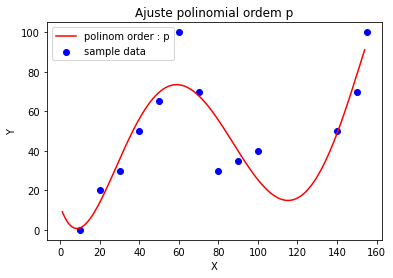

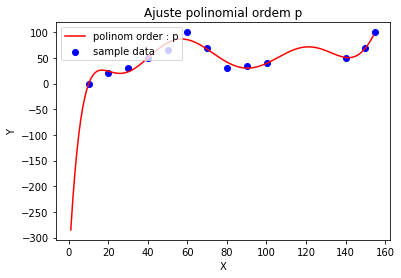

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
#code based on the file: discrete_least_square_approx.pdf

#smaple data
x_teste=[10,20,30,40,50,60,70,80,90,100.120,140,150,155]
y_teste=[0,20,30,50,65,100,70,30,35,40,50,70,100]


def polinom_approx(x,y,order):
  x = pd.DataFrame(x, columns=['x']) # renaming x column to x to better interpret next matrix
  for i in range(2,order+1): # reating the matrix with all orders of x 
    Xi=np.power(x['x'], i)
    x['x'+str(i)]=Xi
  array_ones=np.ones(x.shape[0])
  x.insert(0, "1", array_ones, True) #adding a column of 1 to obtain the constant term
  x.astype(float) #making all values of x a float
  first=np.dot(x.T,x) #covariance matrix
  first.astype(np.float16)
  det=np.linalg.det(first)
  b=[0]
  # the next lines serve to avoid error of non inversible covariance matrix 
  if det==0: 
      singular=True
  else: 
      inverse=np.linalg.inv(first)
      second=np.dot(x.T,y)
      b=np.dot(inverse,second)
  return b


def plot_polinomio(x,b,y_obs):
  y_obtido=[]
  for xi in np.arange(1,max(x)):
    valor=0
    for j in range(len(b)):
        valor+=b[j]*xi**j     
    y_obtido.append(valor)
      
  plt.plot( np.arange(1,max(x)),y_obtido,color='r',label= f"polinom order : p")
  plt.scatter(x,y_obs,color="b", label= "sample data")
  plt.legend(loc="upper left")
  plt.title("Ajuste polinomial ordem p")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.show() 

b=polinom_approx(x_teste,y_teste,5)                                           
plot_polinomio(x_teste,b,y_teste)


b=polinom_approx(x_teste,y_teste,8)
plot_polinomio(x_teste,b,y_teste)


- To evaluate the performance of a model on a dataset, we need to measure how well the predictions made by the model match the observed data.

The most common way to measure this is by using the **mean squared error (MSE)**, which is calculated as:

MSE = (1/n)*Σ(yi – f(xi))2

It’s possible that if we use a different set of observations for the training set and the testing set that our test MSE could turn out to be much larger or smaller.

- One way to avoid this problem is to fit a model several times using a different training and testing set each time, then calculating the test MSE to be the average of all of the test MSE’s.

This general method is known as cross-validation and a specific form of it is known as **leave-one-out cross-validation.**

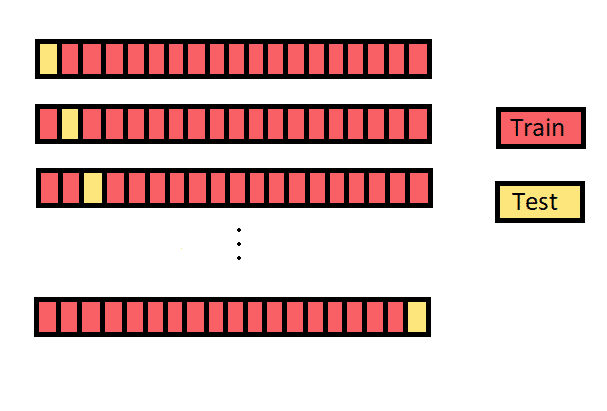

In [ ]:

def leave_one_out(data,window):
  erros = []
  pols = []

  for i in range(window, len(data)-1):
    vec = list(data[:i])+list(data[i+1:])
    x = np.arange(0,len(vec))
    b = polinom_aprox(x,vec,2)
    yObt=[]
    for xi in x:
      valor = 0
      for j in range(len(b)):
        valor+=b[j]*xi**j
        yObt.append(valor)

    error.append((yObt[i]-vec[i])**2)

    return error


  

## 3.10  square error

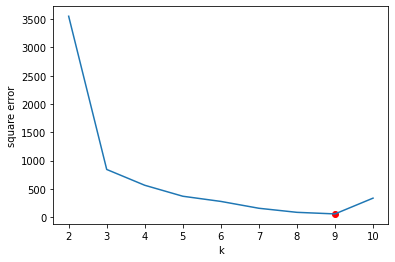

In [ ]:

def find_best_fit_squared(x,y,k_max):
  fits = []
  k_val = []
  for k in range(2,k_max):
    k_val.append(k)
    b=polinom_approx(x,y,k)
    y_obt=[]
    for xi in x:
      valor=0
      for j in range(len(b)):
          valor+=b[j]*xi**j     
      y_obt.append(valor)
    fits.append(sum((np.array(y)-np.array(y_obt))**2)/k)

  plt.plot(k_val, fits)
  plt.xlabel('k')
  plt.ylabel('square error')
  plt.scatter(k_val[np.argmin(fits)],min(fits),color ='r')
  plt.show()
  return  np.arange(2,k_max), fits

window=20
data_xx = np.array(data['accX'][:window])

k_val, fits = find_best_fit_squared(x_teste,y_teste,11)

## 3.10 leave one out

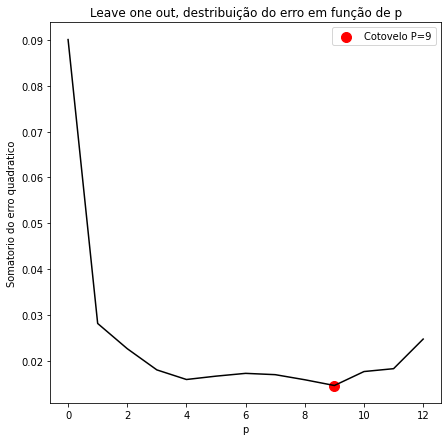

In [ ]:
def leave_one_out(input,order):
    size = len(input)-1
    erro = []
    for i in range(len(input)-1,order,-1):
        ar = np.array(list(input[:i]) + list(input[i+1:]))
        pred = linear_model_order_p_1d(np.array(ar),p=order)
        erro.append((pred[size-i]-input[i])**2)
        
    return erro


def linear_model_order_p_1d(data, p):
    x = data[:len(data)-1]
    x_matriz = np.matrix([np.insert(x[p+i:i:-1],0,1) for i in reversed(range(len(x)-p))]) 
    y = data[len(x)+1:p:-1]
    final_matriz = np.matrix([np.insert(data[p+i:i:-1],0,1) for i in reversed(range(len(data)-p))]) 
    x_t = np.transpose(x_matriz)
    b = np.linalg.pinv(x_matriz).dot(y)
    return np.squeeze(np.asarray(b.dot(final_matriz.T)))


def leave_one_out_main(data, col, p_max=15):  
  erros = []
  p_range=range(p_max)
  window = 30
  sum_errors = []
  for i in range(p_max):
    erros.append(leave_one_out(data[col][:window],i))
  for elem in erros:
    sum_errors.append(sum(elem[:window-p_max]))

  fig = plt.figure(figsize = (7,7))
  plt.scatter(sum_errors.index(min(sum_errors)), min(sum_errors), color="red", label="Cotovelo P="+str(sum_errors.index(min(sum_errors)) ) ,s=100)
  plt.plot(p_range,sum_errors,color = "black")
  plt.title("Leave one out, destribuição do erro em função de p")
  plt.xlabel("p");plt.ylabel("Somatorio do erro quadratico")
  plt.legend()
  plt.show()


leave_one_out_main(data,'accX',13)

# K-means| Z-score

Para cada uma das atividadades e sensores, testamos vários valores de número de clusters, sendo que os que aparecem nos gráficos são os que são os melhores valores (utilizando o método da silhueta).

Relativamente aos outliers nos clusters, estes são definidos como outliers se o número de pontos no dado cluster for inferior a um threshold estipulado (5% do total de pontos em análise). No caso de isso acontecer, todos os pontos desse dado cluster serão considerados outliers.

Fazemos a comparação graficamente entre o K-means e o Z-score no caso de o cluster ser inferior ao dado threshold e, de um modo geral, nunca conseguimos concluir nenhum resultado em concreto, pois estamos a considerar valores fixos (Z-score com k = 3 e threshold de 5%), sendo que por vezes o K-means deteta mais outliers que o Z-score e outras vezes o contrário


##3.10 novo

# **Ex. 4.1**
Para podermos aferir os dados seguem ou não uma distribuição normal, definimos um limiar bastante usado para o $p-value (5\% = 0.05)$, isto é, se o p-value for menor ou igual que este valor, então os dados não seguem uma distribuição normal, rejeitando assim a hipótese nula.

In [ ]:
def getSubset(data,feature, label):
  return data[data['label']==label][feature]
subset = getSubset(data,'acc_mod',1)


contador =0 # contador do numero de subsets que seguem uma distrivuicao gaussiana
for label in range(1,17):
  print("\n>>>>>>>Label = "+ str(label))
  for feature in ["acc_mod","gyro_mod","mag_mod"]:
    subset= getSubset(data,feature,label)
    subset = (subset - subset.mean()) / subset.std()# não esquecer que é preciso normalizar os dados primeiro
    s,pvalue = kstest(subset.to_numpy(),'norm')
    print("label = {0}: kstest: statistics={1}, pvalue={pvalue:.3e}".format(label,round(s,5),pvalue))
    if pvalue>=0.05:
      print("We cannot reject the null hypoteses-> Follows Norm distribuition")
      contador+=1


## Comentário

O teste de Kolmogorov-Silmov entre os nossos dados (normalizados) e uma distribuição gaussiana (também normalizada) resultou em p-values muito inferiores ao usado como referência (0.05).
A conclusão que tiramos (acho eu...) é que os nossos dados não são bem descritos por uma distriuição normal. E, por isso, não tem tanta significância estatística como podiamos pensar só de olhar para o histograma dos dados, usar e "dizer" valor médio.

O Dataset foi adquirido com os participantes a realizar a mesma atividade várias vezes, o que, simplesmente pela questão da repetibilidade, seria de esperar que o teste de Kolmogorov-Silmov desse o resultado contrário ao que deu na verdade.

Uma justificação para o sucedido pode ser a variabilidade que há entre participantes, principalmente a idade e peso (ver citação/print artigo em baixo).


"*Six participants with different gender, age, height, and
weight are recruited to perform nine types of activities: walk forward, walk left, walk right, go upstairs, go downstairs, jump up, run, stand, and sit. [pag.2 pdf]*"

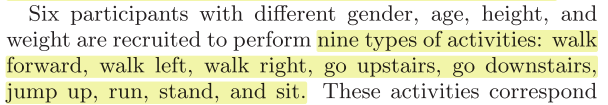

# **Ex. 4.2**

Artigo base: https://pdfs.semanticscholar.org/8522/ce2bfce1ab65b133e411350478183e79fae7.pdf

Highlights artigo:
* Variância tem boa precisão para atividade de Walking, Jogging e Hopping.
* Correlação entre os eixos dos sensores ajudam a diferenciar atividades que involvam translações numa so dimensão como Walking and Running das atividades que involvam translações em varias dimensões como Stair climbing. ## Algoritmos a implementar
* Sigma vs. Energy
* AI (mean value of movement intensity) vs. SMA
* Mean vs. ARATG
* Eigenvalue along heading direction vs. Eigenvalue along gravity direction
Relief-F
* SFC (Wrapper Method based on Single Feature Classification)
* SFS (Wrapper Method based on Sequential Forward Selection)
---

* window: 2s, 50% overlap

157882
83968
81152
139934
142366
89359
43791
6656
5632
6656
5376
3810
7620
3810
1905
1905


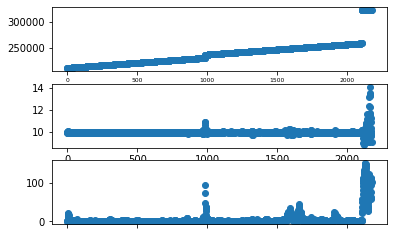

In [ ]:
#Estou a analisar as duracoes das atividades (repetibilidade)
# Acho que pode afetar varias coisas: o resultado do teste KS, a
#representatividade de cada move, e as window
# por exemplo: para o label==3 e partID=10 o que e' que aconteceu ali no final?
label=3
ID=10
temp = data.query('label=={0} and partID=={1}'.format(label,ID))



ax1 = plt.subplot(311)
plt.scatter(range(len(temp)),temp['t'])
plt.tick_params('x', labelsize=6)

# share x only
ax2 = plt.subplot(312, sharex=ax1)
plt.scatter(range(len(temp)),temp['acc_mod'])

ax3 = plt.subplot(313, sharex=ax1)
plt.scatter(range(len(temp)),temp['gyro_mod'])
# make these tick labels invisible
plt.tick_params('x', labelbottom=False)

##plt.figure()
##plt.plot(data.index.tolist())

#------------------------------

for name, group in data.groupby('label', as_index=False):
    print(len(group))
    # daqui da' para ver que as classes nao estao balenciadas

In [ ]:
#########################################################
### PARAMETROS PARA DETERMINAR AS DIMENSOES DA JANELA
#########################################################
 
FREQUENCY = 51.2        # frequencia amostragem sensores (github DATASET); Hz
DELTA_T = 1/FREQUENCY   # intervalo de tempo entre amostras (1/51.2 ~ 20 ms); segundos

T_PAPER = 2             # tamanho janela no paper; segundos
OVERLAP = 0.50          # tamanho do overlap de janelas no paper; percentagem
WINDOW_LENGTH = round(T_PAPER * FREQUENCY) # tamanho da janela; ex: 10 s * 2 Hz = 20 amostras
STEP = int(WINDOW_LENGTH* OVERLAP) # passo para as iteracoes
LAST_INDEX = len(data)-WINDOW_LENGTH # ultimo indice a usar no loop (iteracoes)


#########################################################
### AUXILIARY FUNCTIONS
#########################################################

def modulo(df):
    #funcao modulo mais geral; funciona para um vetor de qualquer dimensao
    return np.sqrt(np.square(df).sum(axis=1))



#########################################################
### STATISTICAL FEATURES (Table 1 pdf)
#########################################################

def mean(window,feature):
    return window[feature].mean()

def median(window,feature):
    return window[feature].median()

def std(window,feature):
    return window[feature].std()

def variance(window,feature):
    return window[feature].var()

def rms(window,feature):
    return ( (window[feature]**2).mean() ) ** 0.5


def avgDerivative(window,feature):
    derivatives = window[feature].diff() / DELTA_T # o * DELTA_T e' porque os nossos dados nao estao separados a  1Hz
    return derivatives.mean()

def skewness(window,feature):
    return window[feature].skew()

def kurtosis(window,feature):
    return window[feature].kurtosis()

def iqr(window,feature):
    percentile75= window[feature].quantile(0.75)
    percentile25= window[feature].quantile(0.25)
    return percentile75-percentile25

def zeroCrossingRate(window,feature):
    # em vez de fazer um ciclo para contar quantas vezes o indice_x e o indice_x+1
    # tem sinais diferentes, vou usar uma propriedade matematica:
    # o Teorema do Valor Intermedio. em especial o corolario de Bolzano
    # referencia: https://en.wikipedia.org/wiki/Intermediate_value_theorem
    
    # temos que usar o metodo .values porque os indices de window[feature][1:] e de window[feature][:-1]
    # sao diferentes, e o pandas tenta (erradamente, para nos) fazer a multiplicacao entre os valores com o mesmo indice
    
    #WINDOW_T = DELTA_T * len(window[feature]) # afinal na formula do artigo o T e' o numero de amostras; nao o tamanho da janela em segundos

    counter = ((window[feature][1:].values * window[feature][:-1].values) < 0 ).sum(axis=0)
    rate = counter /len(window[feature])
    return rate

def meanCrossingRate(window,feature):
    # reciclo codigo e aproveito o zeroCrossingRate()
    # tenho e' que fazer uma copia para nao afetar os calculos futuros (calculos das metricas seguintes)
    window_copy = window[feature].copy() 
    window_copy[feature] = window[feature] - window[feature].mean()
    return zeroCrossingRate(window_copy,feature)

def pairwiseCorrelation(window, feature1, feature2):
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    # para obter a matriz de correlacao toda remover o .iloc[0,1]
    return window[[feature1, feature2]].corr().iloc[0,1]

#verificar todas as funcoes a partir desta (inclusive)
def spectralEntropy(window, feature, normalize=False):
    #https://www.mathworks.com/help/signal/ref/pentropy.html#mw_8905adf9-23d4-42c2-943a-df15280de129

    X = np.fft.fft(window[feature], n=len(window[feature])) # componentes de frequencia
    N = len(X)
    """ PLOTS FFT
    n = np.arange(N)
    T = N/FREQUENCY
    freqs = n/T

    plt.figure(figsize = (12, 6))
    plt.subplot(121)

    plt.stem(freqs, np.abs(X), 'b', \
            markerfmt=" ", basefmt="-b")
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Amplitude |X(freq)|')
    plt.xlim(0, 10)
    """

    S = np.abs(X)**2
    P = S/S.sum()   

    H = -1*np.sum(P*np.log2(P))

    if normalize:
        H= H/np.log2(N)
 
    return H



#########################################################
### PHYSICAL FEATURES (PAG. 2-4 pdf)
#########################################################

#agrupar momentIntensity, meanMomentIntensity e varianceMomentIntensity
def momentIntensity(window,features):
    # atencao: aqui features e' um vetor 3D
    # no fim removo estes warnings
    if len(features)!=3:
        print("WARNING in momentInstensity")
        print("this metric was aspecting a len(features)==3, instead got len=",len(features))

    modulos = modulo(window[features])
    
    # o * FREQUENCY e' para o resultado ser em segundos
    #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.var.html
    #ddof= 0 calcula a variancia da populacao(que e' a expressao do artigo) e nao da amostra    
    AI = modulos.mean()
    VI = modulos.var(ddof=0)
    return AI, VI

def SMA(window,features): # mudar o nome para SMA
    #Normalized Signal Magnitude Area (SMA)
    #WINDOW_T = DELTA_T * len(window[features]) # afinal na formula do artigo o T e' o numero de amostras; nao o tamanho da janela em segundos

    return window[features].abs().to_numpy().sum() / len(window[features]) # ou .sum().sum()


def EVA(window,features):
    #Eigenvalues of Dominant Directions (EVA)
    #https://stackoverflow.com/questions/34808974/find-the-eigenvalues-of-a-subset-of-dataframe-in-python
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cov.html
    #https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigvals.html
    #https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

    #To capture these effects, we calculate the covariance matrix of the
    # acceleration data along x, y,and z axis in each window. The
    # eigenvectors of the covariance matrix correspond to the dominant
    # directions along which intensive human motion occurs
    eigenvalues = np.linalg.eigvals(window[features].cov())

    NUMBER_OF_FEATURES_TO_RETURN=2 # do pdf: "In this work, we use the top two eigenvalues as our features"
    idx = np.argsort(eigenvalues)[::-1][:NUMBER_OF_FEATURES_TO_RETURN]
    #NOTA: The sort order for complex numbers is lexicographic. If both the real and imaginary parts are non-nan then the order is determined by the real parts except when they are equal, in which case the order is determined by the imaginary parts.
    return eigenvalues[idx] # devolver os 2 maiores valores proprios

def CAGH(window,features):
    # Correlation between Acceleration along Gravity and Heading Directions
    # consideramos: gravity: x-axis
    #               heading direction: plano yz 
    accX = features[0];accY = features[1];accZ = features[2]

    headingDirection = modulo(window[[accY,accZ]])
    gravityDirection = window[accX]
    return gravityDirection.corr(headingDirection)

def AVH(window,features):#Averaged Velocity along Heading Direction
    #AVH is approximated by first calculating the averaged velocities
    # along y and z axes over the window, and then computing the
    # Euclidean norm of those two velocities.

    #https://stackoverflow.com/questions/42748566/pandas-diff-giving-0-value-for-first-difference-i-want-the-actual-value-inste
    # vou assumir que os participantes tem condicao fronteira v=0
    velocityY=AVG(window,features[0])
    velocityZ=AVG(window,features[1])

    velocityHeadDirection = np.sqrt(velocityY**2+velocityZ**2)

    return velocityHeadDirection

def AVG(window,feature):
    #WINDOW_T = DELTA_T * len(window[feature]) # intervalo de tempo de integracao

    velocity= np.trapz(window[feature], dx=DELTA_T) # integracao numerica (simpson rule) da aceleracao
    avgVelocity = velocity/len(window[feature])     # dividimos pelo intervalo de tempo de integracao para obter o valor medio (ver imagem:integral_average_value.png)
    return avgVelocity # velocidade media


def ARATG(window,feature): #Averaged Rotation Angles related to Gravity Direction

    #ARATG calculates the cumulative rotation angles around gravity
    # direction. The cumulative sum is then divided by the window
    # length for normalization. Since sensors are at the subject’s
    # front right hip, this feature captures the rotation movement
    # of the human torso around gravity direction.

    # consideramos: gravity: x-axis
    # se features=['gyroX','gyroY','gyroZ']
    
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html
    WINDOW_T = DELTA_T * len(window[feature])

    cumsum = window[feature].sum()
    return cumsum/len(window[feature])

#O artigo nao diz nada sobre remover a componente DC...
# mas... o resultado desta funcao da' (quase) sempre 0 -> frequencia DC
# deixamos essa possibilidade atraves de uma keyword
def DF(window,feature,removeDC=False): #Dominant Frequency
    #The dominant frequency is defined as the frequency
    # corresponding to the maximum of the squared discrete FFT
    # component magnitudes of the signal from each sensor axis

    if removeDC:
        X = np.fft.fft(window[feature]-window[feature].mean, n=len(window[feature]))
    else:
        X = np.fft.fft(window[feature], n=len(window[feature]))

    N = len(X)
    n = np.arange(N)
    T = N/FREQUENCY
    freqs = n/T

    S = np.abs(X)**2
    idxDominant = np.argmax(S)
    return freqs[idxDominant]

def ENERGY(window,feature):
    #Energy is calculated as the sum of the squared discrete FFT
    # component magnitudes of the signal from each sensor axis.
    # The sum is then divided by the window length for normalization.
    
    #The DC component of the FFT is excluded in this sum since it is
    # already measured by the mean feature.
    N=len(window[feature])
    X = np.fft.fft(window[feature]-window[feature].mean(), n=N)
    #ΔF of the points in «Freq» is 1/nΔt.
    deltaf= FREQUENCY/N
    S = np.abs(X)**2 * deltaf
    S = S.sum()/ len(X)

    return S


def AAE(window, features):
    #Averaged Acceleration Energy (AAE)
    #is defined as the mean value of the energy over three **ACCELERATION AXES**.

    return ENERGY(window,features).mean()

def ARE(window, features):
    #Averaged Rotation Energy (ARE)
    #is defined as the mean value of the energy over three **GYROSCOPE AXES**.

    return ENERGY(window,features).mean()



In [ ]:
# funcao para separar os dados todos em pequenas janelas
def sectionate_data_by_window(data, window_length):
  # comeca na primeira linha e ve que tem um certo move na coluna do move
  # depois, ve se na linha (indice + window_length) ainda temos o mesmo move
  # e se ainda temos o mesmo participante! (e' importante porque nao queremos misturar dados de participantes diferentes na mesma janela)
  # se sim, guardamos todos os valores entre (indice e indice+ window_length) no activies_by_window["move"]
  # se nao, (o participante comecou a fazer outra atividade) nao contamos com esses dados

  for interval in range(0,len(data)-window_length,STEP):
    if data.iloc[interval]["label"] == data.iloc[interval+window_length]["label"] \
    and data.iloc[interval]["partID"] == data.iloc[interval+window_length]["partID"]:
        activities_by_window[data.iloc[interval]["label"]].append(data.iloc[interval:interval+window_length])
  return activities_by_window


#activities_by_window = {activityName: [] for i,activityName in enumerate(act_labels)}
activities_by_window = {i: [] for i in range(1,len(act_labels)+1)}

activities_by_window = sectionate_data_by_window(data,WINDOW_LENGTH)

# SE O COLAB ESTIVER A DEMORAR MUITO TEMPO, USAR SO' UM SUBSET PARA SER MAIS RAPIDO
# PARA ISSO, BASTA DESCOMENTAR A LINHA SEGUINTE
#activities_by_window =activities_by_window["Stand"]

# inicializar uma DataFrame para guardar todas as features, para todas as janelas
dfAllFeatures = pd.DataFrame()

# antes de fazer o loop, experimentar para alguns casos para evitar bugs
for key,value in activities_by_window.items():
  print("calculating features for activity:", key)
  print("amount of windows:", len(value))
  for window in value:
  #for window in activities_by_window:
    #########################
    ### STATISTICAL (EXCEPT PAIRWISE CORRRELATION)
    #########################
    statisticalFeatures = {}
    for feature in ['accX','accY','accZ','gyroX','gyroY','gyroZ']:
      statisticalFeatures.update({
      feature+'_mean': mean(window,feature),
      feature+'_median': median(window,feature),
      feature+'_std': std(window,feature),
      feature+'_var': variance(window,feature),
      feature+'_rms': rms(window,feature),
      feature+'_avgDer': avgDerivative(window,feature),
      feature+'_skew': skewness(window,feature),
      feature+'_kurtosis': kurtosis(window,feature),
      feature+'_iqr': iqr(window,feature),
      feature+'_zcr': zeroCrossingRate(window,feature),
      feature+'_mcr': meanCrossingRate(window,feature),
      feature+'_spectralH': spectralEntropy(window,feature,normalize=True)}
      )

    #########################
    ### PAIRWISE CORRRELATION
    #########################
    # loop para as pairwise coor: # testado, funciona bem
    # comecamos com um dictionario vazio e vamos lhe adicionando valores dentro do
    # loop. Por simetria pwc_feat1_feat2 == pwc_feat2_feat1. O loop foi
    # feito de forma a nao perder tempo a repetir esses calculos.
    pairwiseFeatures ={}
    features = ['accX','accY','accZ','gyroX','gyroY','gyroZ']
    for idx1,feat1 in enumerate(features):
      for idx2,feat2 in enumerate(features[idx1+1:]):
        pairwiseFeatures['PWC_'+feat1+'_'+feat2] = pairwiseCorrelation(window,feat1,feat2)

    #########################
    ### PHYSICAL FEATURES
    #########################
    # para estas nao ganhamos muito em fazer loops; fica mais facil de ler assim "por extenso"
    AI,VI =momentIntensity(window,['accX','accY','accZ'])
    EVA1,EVA2 = EVA(window,['accX','accY','accZ'])

    physicalFeatures={
      'AI': AI,
      'VI': VI,
      'SMA': SMA(window,['accX','accY','accZ']),
      'EVA1': EVA1,
      'EVA2': EVA2,
      'CAGH': CAGH(window,['accX','accY','accZ']),
      'AVH': AVH(window,['accY','accZ']),
      'AVG': AVG(window,'accX'),
      'ARATG': ARATG(window,'gyroX'),
      'accX_DF': DF(window,'accX'),
      'accY_DF': DF(window,'accY'),
      'accZ_DF': DF(window,'accZ'),
      'gyroX_DF': DF(window,'gyroX'),
      'gyroY_DF': DF(window,'gyroY'),
      'gyroZ_DF': DF(window,'gyroZ'),
      'accX_ENERGY': ENERGY(window,'accX'),
      'accY_ENERGY': ENERGY(window,'accY'),
      'accZ_ENERGY': ENERGY(window,'accZ'),
      'gyroX_ENERGY': ENERGY(window,'gyroX'),
      'gyroY_ENERGY': ENERGY(window,'gyroY'),
      'gyroZ_ENERGY': ENERGY(window,'gyroZ'),
      'AAE': AAE(window,['accX','accY','accZ']),
      'ARE': ARE(window,['gyroX','gyroY','gyroZ'])
      }
    # agrupar os 3 grupos de features num so' dicionario;
    # tambem adiciono a label da atividade (necessaria para a analise futura)
    allFeatures = {'label': key,**statisticalFeatures, **pairwiseFeatures,**physicalFeatures}
    # guardar os resultados na dataframe com os resultados para todas as janelas
    dfAllFeatures = dfAllFeatures.append(allFeatures,ignore_index=True)

## FIM DO LOOP

# obrigar a coluna das label a ser do tipo int
dfAllFeatures = dfAllFeatures.astype({'label':'int'})

## DEMOROU: 14 min 15 s; 16 min 42 s; 11 min 53 s; 13 m 55 s; 11 min 52 s


calculating features for activity: 1
amount of windows: 2889
calculating features for activity: 2
amount of windows: 1620
calculating features for activity: 3
amount of windows: 1561
calculating features for activity: 4
amount of windows: 2683
calculating features for activity: 5
amount of windows: 2732
calculating features for activity: 6
amount of windows: 1724
calculating features for activity: 7
amount of windows: 830
calculating features for activity: 8
amount of windows: 99
calculating features for activity: 9
amount of windows: 78
calculating features for activity: 10
amount of windows: 100
calculating features for activity: 11
amount of windows: 76
calculating features for activity: 12
amount of windows: 14
calculating features for activity: 13
amount of windows: 31
calculating features for activity: 14
amount of windows: 12
calculating features for activity: 15
amount of windows: 5
calculating features for activity: 16
amount of windows: 6


In [ ]:
pd.set_option('display.max_columns', None)
dfAllFeatures

,label,accX_mean,accX_median,accX_std,accX_var,accX_rms,accX_avgDer,accX_skew,accX_kurtosis,accX_iqr,accX_zcr,accX_mcr,accX_spectralH,accY_mean,accY_median,accY_std,accY_var,accY_rms,accY_avgDer,accY_skew,accY_kurtosis,accY_iqr,accY_zcr,accY_mcr,accY_spectralH,accZ_mean,accZ_median,accZ_std,accZ_var,accZ_rms,accZ_avgDer,accZ_skew,accZ_kurtosis,accZ_iqr,accZ_zcr,accZ_mcr,accZ_spectralH,gyroX_mean,gyroX_median,gyroX_std,gyroX_var,gyroX_rms,gyroX_avgDer,gyroX_skew,gyroX_kurtosis,gyroX_iqr,gyroX_zcr,gyroX_mcr,gyroX_spectralH,gyroY_mean,gyroY_median,gyroY_std,gyroY_var,gyroY_rms,gyroY_avgDer,gyroY_skew,gyroY_kurtosis,gyroY_iqr,gyroY_zcr,gyroY_mcr,gyroY_spectralH,gyroZ_mean,gyroZ_median,gyroZ_std,gyroZ_var,gyroZ_rms,gyroZ_avgDer,gyroZ_skew,gyroZ_kurtosis,gyroZ_iqr,gyroZ_zcr,gyroZ_mcr,gyroZ_spectralH,PWC_accX_accY,PWC_accX_accZ,PWC_accX_gyroX,PWC_accX_gyroY,PWC_accX_gyroZ,PWC_accY_accZ,PWC_accY_gyroX,PWC_accY_gyroY,PWC_accY_gyroZ,PWC_accZ_gyroX,PWC_accZ_gyroY,PWC_accZ_gyroZ,PWC_gyroX_gyroY,PWC_gyroX_gyroZ,PWC_gyroY_gyroZ,AI,VI,SMA,EVA1,EVA2,CAGH,AVH,AVG,ARATG,accX_DF,accY_DF,accZ_DF,gyroX_DF,gyroY_DF,gyroZ_DF,accX_ENERGY,accY_ENERGY,accZ_ENERGY,gyroX_ENERGY,gyroY_ENERGY,gyroZ_ENERGY,AAE,ARE
0,1,2.816928,2.81290,0.081657,0.006668,2.818100,-0.041974,0.104070,0.486731,0.084675,0.000000,0.254902,0.002106,9.085446,9.09570,0.062883,0.003954,9.085662,-0.085418,-0.672440,1.685651,0.072625,0.0,0.294118,0.000152,3.060974,3.03500,0.096789,0.009368,3.062488,0.076293,1.904632,4.557056,0.086825,0.000000,0.117647,0.002374,-0.465372,-0.070195,1.459396,2.129835,1.524967,-0.895782,-1.484488,1.282085,1.166672,0.068627,0.068627,0.495770,1.339943,0.762775,2.349045,5.518011,2.694320,0.007705,1.068988,0.959178,2.635407,0.078431,0.078431,0.563339,0.456789,0.042256,1.253484,1.571223,1.328335,0.146711,1.914516,3.175865,0.664897,0.235294,0.098039,0.556326,-0.430866,0.605386,-0.000879,-0.043536,-0.184121,-0.610711,0.183270,-0.095132,-0.158819,-0.300375,0.135198,0.219422,-0.433714,-0.913784,0.588205,9.993372,0.002283,14.963348,0.014711,0.003241,-0.136348,0.185426,0.054446,-0.465372,0.0,0.0,0.000000,50.698039,0.000000,0.501961,0.338050,0.200471,0.474942,107.978478,279.752319,79.657938,1.013462,467.388735
1,1,2.864813,2.86200,0.088376,0.007810,2.866162,0.099358,-0.237104,-0.098164,0.135050,0.000000,0.225490,0.002319,9.022365,9.01775,0.091226,0.008322,9.022821,-0.008111,0.032134,-0.807555,0.147725,0.0,0.176471,0.000286,3.207150,3.25270,0.153359,0.023519,3.210779,0.162116,-0.259720,-1.414181,0.299075,0.000000,0.029412,0.004502,-0.399238,-0.188890,1.634462,2.671465,1.674713,0.803779,-0.916691,0.263355,1.817285,0.068627,0.058824,0.452877,1.807628,1.395900,2.379447,5.661767,2.978889,3.557427,0.828425,0.047274,2.982452,0.049020,0.107843,0.563309,0.456527,0.024461,1.439275,2.071512,1.503203,-0.769926,1.083254,1.063294,1.448390,0.137255,0.078431,0.506331,-0.472284,0.728639,0.378202,0.072814,-0.369738,-0.729310,-0.270481,-0.083204,0.149454,0.464439,0.191475,-0.307554,-0.309455,-0.904712,0.354728,9.996576,0.003754,15.094327,0.033046,0.004258,-0.055324,0.185178,0.055401,-0.399238,0.0,0.0,0.000000,50.698039,0.000000,0.501961,0.395965,0.421917,1.192362,135.438019,287.040492,105.021598,2.010244,527.500109
2,1,2.646591,2.80950,0.347139,0.120506,2.669039,-0.600155,-0.984057,-0.323593,0.464225,0.000000,0.088235,0.026890,9.056402,8.99730,0.150020,0.022506,9.057632,0.126783,0.883169,-0.202593,0.186425,0.0,0.205882,0.000708,3.260619,3.27810,0.101686,0.010340,3.262188,-0.161660,-0.613508,-0.186721,0.140275,0.000000,0.186275,0.002318,1.494038,1.283650,1.525944,2.328504,2.130217,0.685119,0.625083,0.834080,1.268817,0.029412,0.137255,0.402865,3.703647,2.074750,4.127827,17.038953,5.530724,-2.018416,1.271830,1.125986,4.839852,0.068627,0.078431,0.455785,-1.803470,-0.940175,2.866249,8.215386,3.374515,0.057009,-1.525532,2.109380,2.104515,0.058824,0.058824,0.450449,-0.816574,0.836674,-0.394718,-0.278610,0.409811,-0.626499,0.390870,0.285609,-0.340042,-0.232777,-0.276481,0.261714,0.679458,-0.9153

In [ ]:
# Guarda a matriz com as fetures todas (bloco de codigo anterior)
# em ficheiro csv
#https://cyublog.com/articles/python-en/colab-pandas-three-ways-to-save-dataframe-data/

from google.colab import files
dfAllFeatures.to_csv('dfAllFeatures.csv', index=False) 
files.download('dfAllFeatures.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Ex. 4.3 e 4.4: PCA**

Principal component analysis (PCA) is a technique that transforms high-dimensions data into lower-dimensions while retaining as much information as possible.
https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e

https://towardsdatascience.com/principal-component-analysis-pca-explained-visually-with-zero-math-1cbf392b9e7d

The construction of relevant features is achieved by linearly transforming correlated variables into a smaller number of uncorrelated variables. This is done by projecting (dot product) the original data into the reduced PCA space using the eigenvectors of the covariance/correlation matrix aka the principal components (PCs).

**When/Why** to use PCA
  - PCA technique is particularly useful in processing data where multi-colinearity exists between the features/variables.
  - PCA can be used when the dimensions of the input features are high (e.g. a lot of variables).
  - PCA can be also used for denoising and data compression.

**Disavantage**

 - lost of information
 - data Interpertability    


## Load Data

In [ ]:
# PARA NAO TERMOS QUE CORRER O CODIGO TODO SEMPRE QUE FOR PRECISO,
# GUARDAMOS UM FICHEIRO CSV COM OS RESULTADOS ANTERIORES

# NAO ESQUECER DE CORRER OS IMPORTS

USE_LOCAL_FILE = True # True se queremos usar o ficheiro csv;
                      # False se queremos usar a dataframe em memoria 
if USE_LOCAL_FILE:
  df_main = pd.read_csv('dfAllFeatures.csv')
  df_main
else:
  df_main = dfAllFeatures.copy()

  ## Outra MANEIRA DE LER OS FICHEIROS

  #from google.colab import drive
  #drive.mount('/content/drive')
  #path = "/content/drive/MyDrive/TCD/dfAllFeatures.csv"
  #df_main = pd.read_csv(path);print("DataFrame loaded...")

FileNotFoundError: ignored

## PCA

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1º remover a coluna com o target
df_features = df_main.drop(columns=['label'])        #matriz com as features mas sem o target
df_target =  df_main[['label']]

# 2º normalizar os dados
df_features = df_features.apply(lambda iterator: ((iterator - iterator.mean() )/(iterator.std())))
# 3º usar o pca
# nota: no enunciado pede para calcular o importancia de cada uma

pca = PCA(0.75) 
pca_data = pca.fit_transform(df_features) #projecao dos dados no novo espaco, o espaco das PCA

# numero de componentes do PCA
n_pcs= pca.components_.shape[0]

# descobrir o indice da feature mais importante em cada componente
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = df_features.columns
# descobrir os nomes da features (a partir dos indices)
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# Guardar o resultado numa dataframe
dfPCA = pd.DataFrame(dic.items(), columns = ['Componente','MVFeature'])
dfPCA

,Componente,MVFeature
0,PC0,gyroY_std
1,PC1,accZ_rms
2,PC2,gyroY_mean
3,PC3,accY_median
4,PC4,accZ_median
5,PC5,accY_kurtosis
6,PC6,gyroX_kurtosis
7,PC7,PWC_accY_accZ
8,PC8,PWC_accX_gyroZ
9,PC9,gyroZ_var


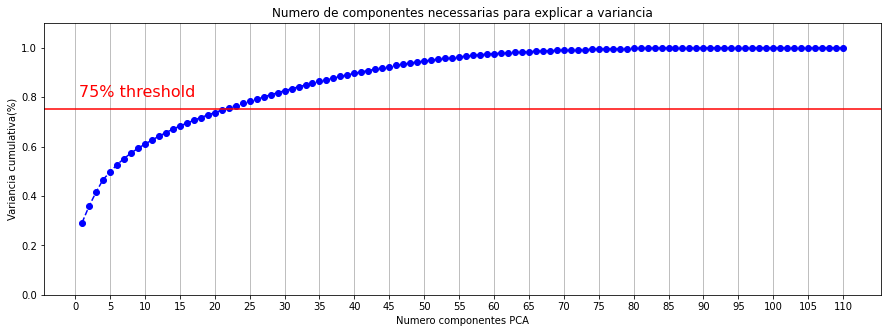

In [ ]:
# Plot com o numero de componentes necessarias para explicar a variancia de 75%
# Se queremos os pontos todos, correr o bloco de codigo anterior com a alteracao: PCA(0.75) -> PCA()
plt.figure(figsize=(15,5))
xi = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Numero componentes PCA')
plt.xticks(np.arange(0, len(pca.explained_variance_ratio_)+1, step=5)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Variancia cumulativa(%)')
plt.title('Numero de componentes necessarias para explicar a variancia')

plt.axhline(y=0.75, color='r', linestyle='-')
plt.text(0.5, 0.80, '75% threshold', color = 'red', fontsize=16)

plt.grid(axis = 'x')
plt.show()

## PCA inverse transform

 by reducing the dimensions with PCA, we have lost information ( pca.explained_variance_ratio_ is the % of information we still have). However with inverse_transform, it tries its best to go back to the original space as well as it can,
 https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [ ]:
pca_data=pd.DataFrame(pca_data,columns = ['Principal vector '+ str(i) for i in range(pca.components_.shape[0])])
print('pca_data')
pca_data

pca_data


,Principal vector 0,Principal vector 1,Principal vector 2,Principal vector 3,Principal vector 4,Principal vector 5,Principal vector 6,Principal vector 7,Principal vector 8,Principal vector 9,...,Principal vector 12,Principal vector 13,Principal vector 14,Principal vector 15,Principal vector 16,Principal vector 17,Principal vector 18,Principal vector 19,Principal vector 20,Principal vector 21
0,-4.460786,-1.306697,-1.123253,-0.721423,1.275616,1.775750,1.552420,1.248314,0.426385,1.573714,...,-0.372193,0.703695,1.002579,-1.975287,0.198930,-0.181184,0.242060,0.948210,-0.706626,-0.332525
1,-3.443799,-2.521176,-1.134449,-2.039294,1.363732,0.300142,0.430575,2.494861,0.999557,1.791101,...,-0.561339,0.670753,1.015155,-2.448580,-0.318533,-0.096845,-0.364106,-1.404832,-1.519194,0.310413
2,-3.594115,-1.968619,0.076200,-0.873858,2.069684,0.376938,1.101811,1.441008,1.575919,-0.015916,...,-0.615531,0.967035,-1.716116,0.216331,0.035184,2.380387,1.277873,1.250929,2.245020,-0.780134
3,-3.372026,-2.475895,-0.578753,-0.888619,2.711917,0.627945,0.938859,1.781913,0.500002,1.359995,...,-0.359389,-0.337705,-0.977266,-2.070183,-1.636950,2.449032,1.316891,-0.167305,0.883113,0.942909
4,-5.342635,-0.736310,-0.287403,0.681967,1.434234,3.040737,1.465880,0.195904,-0.871189,-0.012487,...,1.467592,-0.209540,0.150943,-0.823693,0.492426,1.551308,0.702195,-0.565945,-0.017787,1.045466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14455,1.688617,-3.424937,-0.458171,8.642948,2.045185,-2.567714,-1.237180,-3.724175,1.968278,0.512368,...,-0.528300,1.439650,0.264870,0.659400,-1.078129,0.835510,-0.173024,-3.210679,1.163988,-7.110110
14456,2.734823,2.030224,-0.789721,-0.649272,2.140146,-0.364187,1.776605,1.586878,-0.603832,1.292088,...,-2.410473,1.320374,-2.010769,2.223687,0.392852,0.723415,1.275623,1.076103,-0.252043,-2.167906
14457,3.998897,2.764724,-1.185156,1.310175,2.093534,2.428588,-2.444043,0.610123,0.582943,-0.036734,...,-0.848113,-2.093920,0.630394,-1.650520,-0.375338,-1.732913,-1.088132,-0.792158,-1.370951,0.432642
14458,3.147706,-2.696407,1.756071,-0.303011,-2.555662,-1.308759,0.760554,2.619564,1.041793,-2.532975,...,-0.195670,0.095054,1.666306,1.476911,-0.292487,0.076369,0.891834,-0.765322,1.028573,0.512999


In [ ]:
# TRANSFORMADA INVERSA DO PCA
print('pca_inverse:')
pca_inverse = pd.DataFrame(pca.inverse_transform(pca_data), columns = df_features.columns)
display(pca_inverse)

# Difference between default and inverse DataFrame
# Uma vez que comprimimos o espaco das features atraves do PCA, perdemos alguma
# informacao. Isso fica evidente quando fazemos a transformacao inversa do PCA
# na medida em que nao obtemos exatamente os dados originais
print('Diferenca entre os dados originais e o pca_inverse:')
display(pca_inverse- df_features)

pca_inverse:


,accX_mean,accX_median,accX_std,accX_var,accX_rms,accX_avgDer,accX_skew,accX_kurtosis,accX_iqr,accX_zcr,...,gyroY_DF,gyroZ_DF,accX_ENERGY,accY_ENERGY,accZ_ENERGY,gyroX_ENERGY,gyroY_ENERGY,gyroZ_ENERGY,AAE,ARE
0,-0.113400,-0.105167,-0.691179,-0.375259,-0.246212,-0.405237,-0.211391,0.628393,-0.712884,-0.261931,...,-0.075523,-0.048343,-0.375259,-0.667554,-0.690379,-0.696071,-1.020729,-0.744267,-0.715919,-0.976001
1,0.186833,0.199071,-0.616783,-0.455912,-0.144308,0.351809,-0.070083,-0.140014,-0.506750,-0.066274,...,-0.013608,0.018088,-0.455912,-0.664608,-0.692297,-0.667620,-1.114644,-0.792000,-0.734250,-1.041564
2,0.149514,0.176991,-0.386742,0.105394,0.070337,-0.768473,-0.897782,-0.121972,-0.327076,-0.106135,...,0.325671,-0.062557,0.105394,-1.016435,-0.404180,-0.282103,-0.955064,-1.093445,-0.747909,-1.062347
3,0.017291,0.033493,-0.655642,-0.453542,-0.125870,-0.119392,-0.522190,0.207611,-0.628160,-0.084913,...,0.180167,-0.561428,-0.453542,-0.605136,-0.624866,-0.349607,-0.834160,-0.871152,-0.676450,-0.900072
4,-0.070725,-0.056850,-0.880256,-0.502986,-0.381326,-0.204977,-0.369837,1.283441,-1.062790,0.105514,...,-0.357383,-0.463670,-0.502986,-0.648730,-0.570619,-0.678190,-0.567352,-0.973180,-0.702190,-0.872012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14455,-2.414780,-2.386343,0.376996,0.148936,0.120461,-1.007969,-0.384720,-0.073791,0.567251,-0.203220,...,1.471946,3.834604,0.148936,0.230027,0.764820,-0.411110,-0.767578,-0.559347,0.395325,-0.717248
14456,0.636120,0.643343,1.514340,2.155662,0.502244,-1.458919,-0.739391,-0.115620,1.561695,0.819145,...,0.186741,0.522851,2.155662,0.057652,0.121715,-0.169793,-0.114811,0.522203,0.598189,0.187217
14457,-0.001232,0.009810,0.640169,0.204789,-0.266624,1.126788,-0.239731,-0.072440,0.589849,1.238035,...,0.240026,0.219160,0.204789,2.381514,0.290028,-0.103639,0.326034,-0.203061,1.683537,0.037946
14458,-0.339572,-0.312837,0.017240,-0.285211,-1.206077,0.269145,-0.455414,-0.385466,0.013316,0.145478,...,-0.139133,-0.382805,-0.285211,-0.299900,1.115023,1.069710,0.499641,-0.494084,0.038859,0.145162


Diferenca entre os dados originais e o pca_inverse:


,accX_mean,accX_median,accX_std,accX_var,accX_rms,accX_avgDer,accX_skew,accX_kurtosis,accX_iqr,accX_zcr,...,gyroY_DF,gyroZ_DF,accX_ENERGY,accY_ENERGY,accZ_ENERGY,gyroX_ENERGY,gyroY_ENERGY,gyroZ_ENERGY,AAE,ARE
0,-0.271134,-0.267738,0.171120,0.119445,-0.117176,-0.329737,-0.354570,0.672517,0.141024,0.050720,...,0.258127,0.383648,0.119445,-0.040309,-0.102381,-0.046226,-0.251664,-0.013704,-0.025033,-0.135190
1,0.005601,0.012354,0.232765,0.037780,-0.049692,0.194566,0.328811,0.163235,0.275102,0.246377,...,0.320042,0.450079,0.037780,-0.038815,-0.115538,-0.018584,-0.345644,-0.061651,-0.047627,-0.201014
2,0.075365,0.016092,-0.028330,0.499205,0.306122,0.226228,0.687903,0.281148,-0.016082,0.206516,...,0.659320,0.398448,0.499205,-0.395353,0.183047,0.367445,-0.191253,-0.365733,-0.085938,-0.225574
3,0.155933,0.225689,-0.180799,-0.025320,0.423508,0.582878,-1.819277,0.742262,-0.304900,0.227738,...,0.513817,-0.100423,-0.025320,0.015792,-0.035338,0.299453,-0.070949,-0.143638,-0.005534,-0.063762
4,0.143860,0.153222,-0.057488,-0.011681,0.290109,-0.329078,-0.591325,1.380792,-0.278471,0.418166,...,-0.023733,-0.031679,-0.011681,-0.023242,0.021730,-0.027006,0.202806,-0.242577,-0.012095,-0.030457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14455,-0.159638,-0.086792,0.176560,0.284731,0.695655,-0.747477,-1.109882,0.498898,0.122377,0.109431,...,1.805596,1.394172,0.284731,-0.482671,0.857084,-0.095505,-0.450799,-0.351383,-0.011407,-0.411494
14456,0.179528,-0.142995,-0.682206,0.115145,-0.084712,1.555297,2.020737,-1.019480,0.508930,0.680830,...,0.520390,0.983856,0.115145,-0.225256,-0.151658,0.284403,0.267977,0.054063,-0.160240,0.198774
14457,0.090832,0.155091,-0.297661,-0.235027,0.072127,-0.901141,-0.234564,-0.088180,0.198330,-0.253180,...,0.573675,-2.192256,-0.235027,0.032769,0.223996,0.050206,-0.132997,-0.066011,0.025034,-0.090577
14458,0.196002,0.235601,-0.330483,-0.243005,-0.187457,-0.610863,0.012538,-0.224388,-0.438946,-0.443803,...,0.194516,0.078200,-0.243005,0.028315,0.642846,-0.153791,0.557063,-0.114161,0.134505,0.187535


PCA Fit Inverse Transform

#PCA dados iniciais

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

data_teste = data[['accX','accX','accZ','gyroX','gyroY','gyroZ','magX','magY','magZ']]
columns = data_teste.keys()
target = data['move']
data_teste = preprocessing.normalize(data_teste)

pca = PCA(0.75)    #PCA melhores features para explicarX% do dataset

pca_data = pca.fit_transform(data_teste)
print("Numero de componentes", pca.n_components_)
print("Importância de cada Principal Component", pca.explained_variance_ratio_)


Numero de componentes 3
Importância de cada Principal Component [0.36794731 0.26341052 0.22239198]


In [ ]:
pca_data=pd.DataFrame(pca_data,columns = ['Principal vector '+ str(i) for i in range(pca.components_.shape[0])])
display(pca_data)

,Principal vector: 1,Principal vector: 2,Principal vector: 3
0,-0.397674,-0.364230,-0.382735
1,-0.496888,-0.355667,-0.317633
2,-0.583173,-0.324167,-0.261574
3,-0.646294,-0.332878,-0.196157
4,-0.688334,-0.310316,-0.163629
...,...,...,...
781817,-0.408744,-0.152546,-0.417575
781818,-0.346117,-0.209315,-0.428136
781819,-0.310955,-0.110740,-0.457012
781820,-0.311949,-0.134796,-0.455276


Dataset que retiramos usando as componentes principais, é de epserar que seja diferente do incial pois retiramos informação

In [ ]:
pd.DataFrame(pca.inverse_transform(pca_data), columns = columns)

,accX,accX,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ
0,0.405308,0.405308,0.562064,0.158464,0.539161,-0.028406,0.023075,0.079172,0.167564
1,0.370248,0.370248,0.519605,0.160375,0.621680,0.025265,0.020147,0.073634,0.154873
2,0.338797,0.338797,0.481162,0.152281,0.681937,0.090563,0.017555,0.068596,0.143406
3,0.304558,0.304558,0.440360,0.160220,0.742238,0.111569,0.014662,0.063169,0.131092
4,0.286104,0.286104,0.417836,0.153573,0.768377,0.148475,0.013144,0.060186,0.124355
...,...,...,...,...,...,...,...,...,...
781817,0.412632,0.412632,0.567117,0.071655,0.445917,0.144160,0.024003,0.079812,0.169451
781818,0.421320,0.421320,0.578957,0.092499,0.419678,0.067814,0.024639,0.081260,0.172809
781819,0.431506,0.431506,0.589732,0.050461,0.341661,0.127780,0.025634,0.082584,0.176148
781820,0.431843,0.431843,0.590505,0.060295,0.354063,0.109578,0.025628,0.082706,0.176352


# **Ex. 4.5**
Full implementation in part B

Full description and discussion in attached paper

# **Ex. 4.6**
Full implementation in part B

Full description and discussion in attached paper
